In [1026]:
import json
import pandas as pd
import numpy as np
import pymongo
import os.path
import seaborn as sns
import re
import matplotlib.pyplot as plt
import string
import scipy.sparse as sp
import time
import itertools as it

from scipy.stats import wilcoxon
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn import preprocessing, metrics
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC

tqdm_notebook().pandas()
sns.set_context('paper')
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [536]:
!rm md_colors.py*; wget -q --no-check-certificate https://gist.github.com/vlandeiro/a97f22261e85427ef7811a3fc9c1afba/raw/d2bdb2a614ceac31434dbe758a97c2dac3c6cd71/md_colors.py
%run md_colors.py

# Load data

## Control and treatment groups

###  Load users information

In [4]:
n_users = pd.read_csv("./nosport_users_stats")
s_users = pd.read_csv("./sport_users_stats")

for df in [n_users, s_users]:
    df.index = df['id']

In [5]:
s_users.shape, n_users.shape

((1160, 7), (1160, 7))

### Load matches

Load matches file.

In [6]:
matches = pd.read_csv("/data/1/sporty/users/classification/matches.txt", header=None, names=['sport', 'nosport'])

Some users have been matched twice to a sport users, we remove these duplicate entries here although we missed them in 2014.

In [7]:
matches = matches.drop_duplicates(subset=['nosport'])
n_users = n_users.drop_duplicates(subset=['id'])

Align users' dataframes.

In [8]:
s_users = s_users.loc[matches.sport.tolist()]
s_users.index = np.arange(s_users.shape[0])
n_users = n_users.loc[matches.nosport.tolist()]
n_users.index = np.arange(n_users.shape[0])

In [9]:
s_users.shape, n_users.shape

((1153, 7), (1153, 7))

Remove users that are in both groups and their match that we missed last time.

In [10]:
# find users in both groups
both_groups = set(s_users['id']) & set(n_users['id'])

# find lines with users in both groups
s_idx_to_remove = s_users.id.where(s_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
n_idx_to_remove = n_users.id.where(n_users.id.apply(lambda _: _ in both_groups)).dropna().index.tolist()
idx_to_remove = s_idx_to_remove + n_idx_to_remove

# remove lines from users' dataframes
s_users = s_users.drop(idx_to_remove, axis=0)
n_users = n_users.drop(idx_to_remove, axis=0)

In [11]:
s_users.shape, n_users.shape

((1137, 7), (1137, 7))

### Load tweets for each user 

For each user, load scraped tweets, without auto-generated tweets by physical applications, and removing retweets.

In [12]:
def load_tweets(user_id, data_dir, remove_hash=None, keep_rt=False):
    user_p = os.path.join(data_dir, user_id)
    tweets = []
    with open(user_p) as fd:
        for l in fd:
            o = json.loads(l)
            # check for retweets
            if not keep_rt and 'retweeted_status' in o:
                keep_tw = False
            else:
                # check for hashtags to avoid
                h = set([_['text'].lower() for _ in o['entities']['hashtags']])
                keep_tw = remove_hash is None or not (h & set(remove_hash))
            
            if keep_tw:
                tweets.append(o['text'])
    return tweets
    
auto_hash = ['runkeeper', 'nikeplus', 'runtastic', 'endomondo', 'mapmyrun', 'strava', 'cyclemeter', 'fitstats', 'mapmyfitness', 'runmeter']

def load_tweets_sport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/sport/", remove_hash=auto_hash)
    
def load_tweets_nosport(user_id):
    return load_tweets(user_id, "/data/1/sporty/tweets/from_users/no_sport/", remove_hash=auto_hash)

In [13]:
s_users['tweets'] = s_users.id.astype(str).progress_apply(load_tweets_sport)
n_users['tweets'] = n_users.id.astype(str).progress_apply(load_tweets_nosport)

In [15]:
s_users['tweets_count'] = s_users.tweets.apply(len)
n_users['tweets_count'] = n_users.tweets.apply(len)

Drop users' (and their match) that have no remaining tweets.

In [16]:
notweets_nidx = n_users.index[n_users.tweets_count == 0].tolist()
notweets_sidx = s_users.index[s_users.tweets_count == 0].tolist()
notweets_idx = notweets_nidx + notweets_sidx

In [17]:
s_users = s_users.drop(notweets_idx)
n_users = n_users.drop(notweets_idx)

## Mood annotated data

In [86]:
def load_labeled_mood(p):
    tweets = []
    with open(p) as fd:
        for l in tqdm_notebook(fd):
            o = json.loads(l)
            tweets.append({k: o[k] for k in ['text', 'AH', 'DD', 'TA']})
    return pd.DataFrame(tweets)

mood_tweets_df = load_labeled_mood("/data/1/sporty/tweets/labeled/3K_labeled")

### Load LIWC lexicon

In [18]:
''' Data structure and utility functions for reading and querying a LIWC
lexicon. Data described here:
http://homepage.psy.utexas.edu/homepage/faculty/pennebaker/reprints/LIWC2001.pdf
'''

from collections import defaultdict
import os


class Lexicon(object):
    """
    >>> import tempfile
    >>> tf = tempfile.NamedTemporaryFile()
    >>> tf.write("%\\n1\\tPronoun\\n2\\tI\\n3\tGreet\\n%\\ni\\t01 02\\nhis\\t01\\nhi*\t03")
    >>> tf.flush()
    >>> d = Lexicon(tf.name)
    >>> d.categories_for_tokens(['i', 'his'])
    [[u'Pronoun', u'I'], [u'Pronoun']]
    >>> d.categories_for_tokens(['his'])
    [[u'Pronoun']]
    >>> cts = d.counts_for_tokens(['i', 'his'])
    >>> cts[u'I']
    1
    >>> cts[u'Pronoun']
    2
    >>> d.categories_for_tokens(['zebra'])
    [[]]
    >>> d.categories_for_tokens(['hithere'])
    [[u'Greet']]
    """

    def __init__(self, dict_file=None):
        self.dict_file = dict_file
        self.load_dictionary(dict_file)

    def parse_categories(self, catText):
        lines = catText.split("\n")
        self.categories = {}
        for line in lines:
            if len(line) > 0:
                key, val = line.split()
                self.categories[str(key)] = str(val)

    def parse_patterns(self, regExps):
        lines = regExps.split("\n")
        self.exact_patterns = {}
        self.prefix_patterns = {}
        for line in lines:
            if len(line) > 0 and not line.startswith('//'):
                vals = line.split()
                exp = vals[0]
                ids = [str(int(v)) for v in vals[1:]]
                if '*' in exp:
                    self.prefix_patterns[exp[:-1]] = ids
                else:
                    self.exact_patterns[exp] = ids

    def load_dictionary(self, dict_file):
        dict_text = open(dict_file).read()
        as_list = dict_text.split("%")
        self.parse_categories(as_list[1])
        self.parse_patterns(as_list[2])

    def categories_for_token(self, word):
        result = []
        if word in self.exact_patterns:
            result.extend(self.exact_patterns[word])
        else:
            for i in range(0, len(word)):
                if word[:-i] in self.prefix_patterns:
                    result.extend(self.prefix_patterns[word[:-i]])
        return [self.categories[c] for c in result]

    def categories_for_tokens(self, tokens):
        """ Returns a list of lists. For each token, create a list of categories
        it belongs to."""
        return [self.categories_for_token(token) for token in tokens]

    def counts_for_tokens(self, tokens):
        """ Returns a dict mapping categories to counts from this list of
        tokens. """
        cats = self.categories_for_tokens(tokens)
        d = defaultdict(lambda: 0)
        for a in cats:
            for b in a:
                d[b] += 1
        return d
    
lex = Lexicon("./liwc.dic")

###  Load emoticons 

In [19]:
emoticon_df = pd.read_csv("emoticons", sep=" ", header=None, names=['tag', 'emoticon'], index_col=1)
emoticon_dict = emoticon_df.to_dict(orient='dict')['tag']

###  Build features encoding

Build tokenizer

In [20]:
def tokenize(text, keep_hashtags=False, keep_mentions=True, keep_urls=True,
             collapse_hashtags=True, collapse_mentions=True, collapse_urls=True, collapse_digits=True, 
             limit_repeats=True, bigrams=True, liwc=True):
    punc = string.punctuation + "—“"
    text = re.sub("\s+", " ", text.lower())
    if not keep_hashtags:
        text = re.sub('#\S+', '', text)
    elif collapse_hashtags:
        text = re.sub('#\S+', 'HASHTAG', text)
    else:
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        
    if not keep_mentions:
        text = re.sub('@\S+' , '', text)
    elif collapse_mentions:
        text = re.sub('@\S+', 'MENTION', text)
    
    if not keep_urls:
        text = re.sub('http\S+', '', text)
    elif collapse_urls:
        text = re.sub('http\S+', 'URL', text)
    
    if limit_repeats:
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
    if collapse_digits:
        text = re.sub(r'[0-9]+', 'NUMBER', text)
    splits = text.split()
    
    punc_tokens = []
    word_tokens = []
    liwc_tokens = []
    for tok in splits:
        if tok in emoticon_dict:
            word_tokens.append(emoticon_dict[tok])
        elif keep_mentions and tok[0] == '@':
            word_tokens.append(tok)
        else:
            tok = tok.strip(punc)
            if tok:
                word_tokens.append(tok)
        if liwc:
            liwc_tokens.extend(["LIWC_" + _ for _ in lex.categories_for_token(tok)])
    
    liwc_tokens = list(set(liwc_tokens))
    bigram_tokens = ["_".join(_) for _ in zip(word_tokens, word_tokens[1:])] if bigrams else []
    
    return word_tokens + bigram_tokens + liwc_tokens

### Build classifier for each dimension

Apply to 3 mood dimensions.

In [797]:
moods = ['AH', 'DD', 'TA']
vecs = {}
kbests = {}
plines = {}
Xs = {}
clfs = {}
features = {}
top_features = {}
n_features = 'all'

for m in tqdm_notebook(moods):
    # build pipeline
    vecs[m] = TfidfVectorizer(tokenizer=tokenize, min_df=2, binary=True)
    kbests[m] = SelectKBest(chi2, n_features)
    plines[m] = pipeline = Pipeline([('tfidf', vecs[m]), ('chi2', kbests[m])])
    
    # build doc term matrix
    y = mood_tweets_df[m]
    Xs[m] = plines[m].fit_transform(mood_tweets_df.text, y)
    # get labels

    # train classifier
    clfs[m] = LogisticRegression(class_weight='balanced')
    clfs[m].fit(Xs[m],y)
    
    # retrieve features
    support = kbests[m].get_support()
    features[m] = np.array(vecs[m].get_feature_names())[support]
    top_features[m] = [(features[m][i], clfs[m].coef_[0][i]) for i in clfs[m].coef_[0].argsort()[::-1]]

###  Top features for each dimension

In [800]:
for m in moods:
    print("Top features for", m)
    for i, (w,c) in enumerate(top_features[m][:20]):
        print("{:>5}. {:.<40}{:>4}".format(i, w, "%.3f" % c))
    print('-'*100)

Top features for AH
    0. LIWC_Anger..............................4.666
    1. hate....................................3.326
    2. LIWC_Swear..............................3.254
    3. dumb....................................3.114
    4. your....................................2.797
    5. upset...................................2.745
    6. fuck....................................2.419
    7. LIWC_Negemo.............................2.386
    8. rude....................................2.295
    9. bitch...................................2.291
   10. irritated...............................2.283
   11. shit....................................2.113
   12. shut....................................2.105
   13. fucking.................................2.016
   14. ignorant................................1.865
   15. why.....................................1.763
   16. stupid..................................1.703
   17. being...................................1.698
   18. freakin............

### Cross validation

In [21]:
def cv(data, n_folds=10):
    results = {}

    for m in tqdm_notebook(moods):
        y_probs = []
        y_preds = []
        y_trues = []
        for tr, te in tqdm_notebook(KFold(data.shape[0], n_folds, shuffle=True, random_state=123456)):
            data_tr, data_te = data.iloc[tr], data.iloc[te]
            y_tr, y_te = data_tr[m], data_te[m]
            X_tr = plines[m].fit_transform(data_tr.text, y_tr)

            X_te = plines[m].transform(data_te.text)

            clf = LogisticRegression(class_weight='balanced')
            clf.fit(X_tr, y_tr)
            y_prob = clf.predict_proba(X_te)[:,1]
            y_pred = clf.predict(X_te)

            y_trues.extend(y_te)
            y_preds.extend(y_pred)
            y_probs.extend(y_prob)
    
        results[m] = {'y_true': y_trues, 'y_pred': y_preds, 'y_prob': y_probs}
    return results

In [802]:
results_cv = cv(mood_tweets_df, 10)

ROC curves for each dimension.

In [22]:
def roc_curves(results):
    fig, ax = plt.subplots(figsize=(8,6))
    colors = ['r','g','b']
    for m, c in zip(moods,colors):
        fpr, tpr, thresh = metrics.roc_curve(results[m]['y_true'], results[m]['y_prob'], drop_intermediate=True)
        ax.plot(fpr, tpr, label=m, color=c, alpha=0.7)
        ax.plot(fpr, thresh, label=m + " threshold", linestyle='-.', color=c)
        plt.legend(loc=4)
        print("%s ROC AUC: %.3f" % (m, metrics.roc_auc_score(results[m]['y_true'], results[m]['y_prob'])))
    ax.set_ylim([0,1])
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.plot([0,1],[0,1], color='k', linestyle='--', linewidth=0.5)
        
roc_curves(results_cv)

NameError: name 'results_cv' is not defined

Precision recall curve for each dimension.

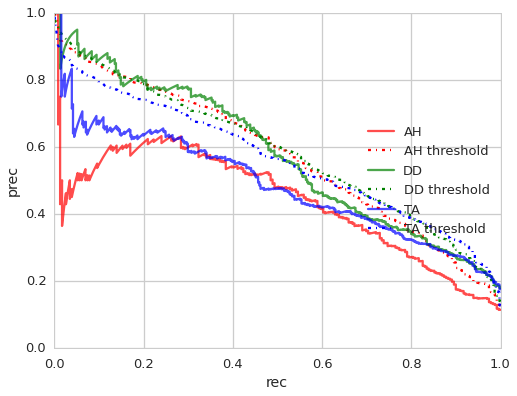

In [829]:
def prec_rec_curves(results):
    fig, ax = plt.subplots(figsize=(8,6))
    colors = ['r','g','b']
    for m, c in zip(moods,colors):
        prec, rec, thresh = metrics.precision_recall_curve(results[m]['y_true'], results[m]['y_prob'], pos_label=1)
        thresh = np.hstack([thresh, [1]])
        ax.plot(rec, prec, label=m, color=c, alpha=0.7)
        ax.plot(rec, thresh, label=m + " threshold", linestyle='-.', color=c)
        plt.legend(loc=7)
    ax.set_ylim([0,1])
    ax.set_xlabel('rec')
    ax.set_ylabel('prec')
        
prec_rec_curves(results_cv)

Pick threshold for best precision (tp/(tp+fp)), minimize false positives.

In [809]:
thresholds = {'AH': .5, 'DD': .5, 'TA': .5}
# thresholds = {'AH': .1, 'DD': .22, 'TA': .18}
# thresholds = {'AH': .6, 'DD': .6, 'TA': .6}
# thresholds = {'AH': .99, 'DD': .99, 'TA': .99}

for m in moods:
    print(m)
    t = thresholds[m]
    y_pred_thresh = (np.array(results_cv[m]['y_prob']) > t).astype(int)
    print(y_pred_thresh.sum())
    print(metrics.classification_report(results_cv[m]['y_true'], y_pred_thresh))

AH
341
             precision    recall  f1-score   support

          0       0.96      0.91      0.93      2138
          1       0.40      0.60      0.48       229

avg / total       0.90      0.88      0.89      2367

DD
546
             precision    recall  f1-score   support

          0       0.93      0.85      0.89      1998
          1       0.44      0.64      0.52       369

avg / total       0.85      0.81      0.83      2367

TA
555
             precision    recall  f1-score   support

          0       0.92      0.84      0.88      1986
          1       0.42      0.61      0.50       381

avg / total       0.84      0.80      0.82      2367



## Annotate users from treatment and control groups.

Train classifiers on the all the annotated instances.

In [810]:
moods = ['AH', 'DD', 'TA']
vecs = {}
kbests = {}
plines = {}
Xs = {}
clfs = {}
features = {}
top_features = {}
n_features = 160

for m in tqdm_notebook(moods):
    # build pipeline
    vecs[m] = TfidfVectorizer(tokenizer=tokenize, min_df=3, max_df=0.95)
    kbests[m] = SelectKBest(chi2, n_features)
    plines[m] = pipeline = Pipeline([('tfidf', vecs[m]), ('chi2', kbests[m])])
    
    # build doc term matrix
    y = mood_tweets_df[m]
    Xs[m] = plines[m].fit_transform(mood_tweets_df.text, y)
    # get labels

    # train classifier
    clfs[m] = LogisticRegression(class_weight='balanced')
    clfs[m].fit(Xs[m],y)
    
    # retrieve features
    support = kbests[m].get_support()
    features[m] = np.array(vecs[m].get_feature_names())[support]
    top_features[m] = [(features[m][i], clfs[m].coef_[0][i]) for i in clfs[m].coef_[0].argsort()[::-1]]

Build termdoc matrix for each user.

In [811]:
for m in tqdm_notebook(moods):
    f = lambda _: plines[m].transform(_)
    n_users['termdoc_' + m] = n_users.tweets.progress_apply(f)
    s_users['termdoc_' + m] = s_users.tweets.progress_apply(f)

Scale termdoc matrix and compute probability of each class for each user.

In [812]:
for m in tqdm_notebook(moods):
    f = lambda _: clfs[m].predict_proba(_)
    n_users['prob_' + m] = n_users['termdoc_' + m].progress_apply(f)
    s_users['prob_' + m] = s_users['termdoc_' + m].progress_apply(f)    

Compute average score for each user.

In [813]:
f = lambda _: np.mean(_[:,1])

for m in tqdm_notebook(moods):
    n_users['avg_prob_' + m] = n_users['prob_' + m].apply(f)
    s_users['avg_prob_' + m] = s_users['prob_' + m].apply(f)

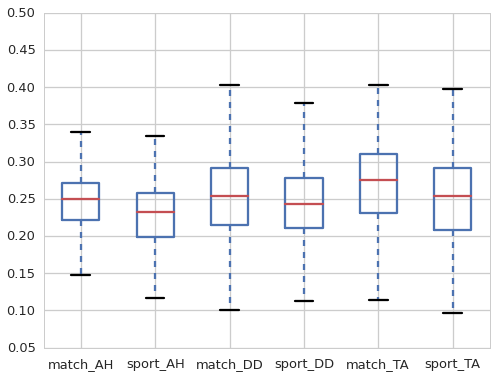

In [827]:
compare_avg_df = pd.DataFrame()
for m in moods:
    compare_avg_df['match_' + m] = n_users['avg_prob_' + m]
    compare_avg_df['sport_' + m] = s_users['avg_prob_' + m]
#     compare_avg_df['diff_' + m] = n_users['avg_prob_' + m] - s_users['avg_prob_' + m]
    
compare_avg_df.plot(kind='box', figsize=(8,6))#, ylim=[-0.1,.22])

Percent change

In [819]:
def perc_change(before, after):
    return 100 * (after - before) / before

for m in moods:
    before = n_users['avg_prob_' + m].mean()
    after = s_users['avg_prob_' + m].mean()
    w, p = wilcoxon(n_users['avg_prob_' + m], s_users['avg_prob_' + m])
    print("Dimension {}: {}% Change, p-value = {}".format(m, "%.2f" % perc_change(before, after), "%.3g" % p))

Dimension AH: -6.48% Change, p-value = 1.76e-22
Dimension DD: -3.64% Change, p-value = 4.84e-06
Dimension TA: -7.05% Change, p-value = 3.29e-16


Compute prediction for each tweets for each user given a threshold for each dimension.

In [820]:
thresholds = {'AH': .5, 'DD': .5, 'TA': .5}

for m in tqdm_notebook(moods):
    t = thresholds[m]
    f = lambda _: (_[:, 1] > t).astype(int)
    n_users['pred_' + m] = n_users['prob_' + m].apply(f)
    s_users['pred_' + m] = s_users['prob_' + m].apply(f)

Compute ratio of positive tweets for each dimension and each user.

In [822]:
f = lambda _: np.sum(_)/np.shape(_)[0]
for m in tqdm_notebook(moods):
    n_users['ratio_pos_' + m] = n_users['pred_' + m].apply(f)
    s_users['ratio_pos_' + m] = s_users['pred_' + m].apply(f)    

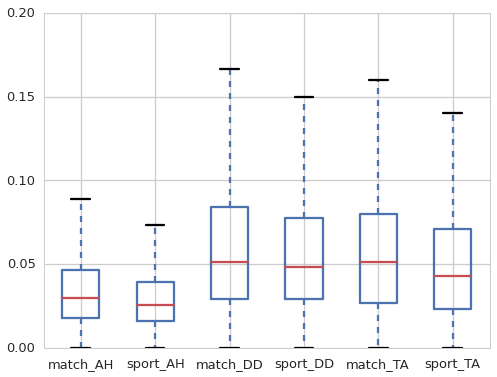

In [826]:
compare_ratio_df = pd.DataFrame()
for m in moods:
    compare_ratio_df['match_' + m] = n_users['ratio_pos_' + m]
    compare_ratio_df['sport_' + m] = s_users['ratio_pos_' + m]
#     compare_ratio_df['diff_' + m] = n_users['ratio_pos_' + m] - s_users['ratio_pos_' + m]
    
compare_ratio_df.plot(kind='box', figsize=(8,6), ylim=[0,.2])

# Topic analysis 

## Clustering helpers

In [23]:
def kmeans_top_fts(kmeans, X, feature_names, n_top_features):
    df = pd.DataFrame()
    X_sum = X.sum(axis=0).A1
    for cl_i in range(kmeans.n_clusters):
        in_cluster_i = np.where(kmeans.labels_ == cl_i)
        X_sum_i = X[in_cluster_i].sum(axis=0).A1
        top_fts_idx = np.argsort(X_sum_i)[::-1]
        df['cluster_%d' % (cl_i + 1)] = feature_names[top_fts_idx][:n_top_features]
    
    return df

In [24]:
def cluster_users_tweets(users, col='tweets', n_clusters=10, max_iter=10, n_words=50, seed=123456, stop_words='english',
                         tokenize_kwargs=dict(keep_hashtags=True, collapse_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False)):
    t0 = time.time()
    print("Vectorize data...")
    vec = TfidfVectorizer(analyzer='word', tokenizer=lambda _: tokenize(_, **tokenize_kwargs),
                          binary=True, min_df=3, max_df=.95, max_features=50000, stop_words=stop_words)
    col_obj = users[col] if type(col) is str else col
    X = vec.fit_transform(col_obj.apply(lambda _: " ".join(_)))
    t1 = time.time()
    print("Done in %.2fs." % (t1-t0))
    feature_names = np.array(vec.get_feature_names())
    print("%d features." % len(feature_names))
    print("Run KMeans clustering...")
    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=seed)
    kmeans.fit(X)
    t2 = time.time()
    print("Done in %.2fs." % (t2-t1))
    
    return vec, feature_names, X, kmeans, kmeans_top_fts(kmeans, X, feature_names, n_words)

## Load food-related datasets

### FooDB dataset

In [25]:
foodb_foods = pd.read_csv("foodb_2016-11-18/foods.csv", escapechar="\\")
foodb_foods = foodb_foods[foodb_foods.food_group != 'Animal foods']
colors = set(['blue', 'red', 'green', 'yellow', 'orange', 'white', 'black'])
food_parts = foodb_foods.name.str.lower()\
                        .apply(lambda _: re.sub(r'[%s]' % re.escape(string.punctuation), "", _).split())\
                        .apply(lambda _: "_".join([x for x in _ if x not in colors]))

In [26]:
foodb_flavors = pd.read_csv("foodb_2016-11-18/flavors.csv")
flavor_parts = foodb_flavors.name.str.lower()\
                        .apply(lambda _: re.sub(r'[%s]' % re.escape(string.punctuation), "", _).split())\
                        .apply(lambda _: "_".join([x for x in _ if x not in colors]))

In [27]:
foodb_words = set(food_parts)# | set(flavor_parts.unique())

### Filter using FooDB keywords and keywords from Weber's paper

In [28]:
def load_weber_lexicon(p):
    line_sep = "==="
    add_to_df = False
    collected = []
    with open(p) as fd:
        for l in fd:
            l = l.strip()
            if l:
                if l.startswith(line_sep):
                    add_to_df = not add_to_df
                    continue
                if add_to_df:
                    collected.append(l.strip().split('\t'))
    df = pd.DataFrame(collected, columns=['food_name', 'avg_cal_per_serving', 'food_cat'])
    df['food_name'] = df.food_name.apply(lambda _: "_".join(_.split()))
    df.avg_cal_per_serving.astype(float, inplace=True)
    return df

weber_lexicon = set(load_weber_lexicon("./twitter_food_calorie_lexicon.txt").food_name)
weber_df = load_weber_lexicon("./twitter_food_calorie_lexicon.txt")

In [663]:
food_dict = defaultdict(lambda: '')
merge_cat_dict = {
    'spices and herbs': 'herbs and spices',
    'animal foods': 'meats',
    'animal': 'meats',
    'meaty': 'meats',
    'baked products': 'baking goods',
    'fatty': 'fats and oils',
    'fruity': 'fruits',
    'legumes': 'vegetables',
    'vegetable': 'vegetables',
    'snacks': 'snack foods',
    'aquatic foods': 'seafood',
    'wine_like': 'alcoholic beverages',
    'nutty': 'nuts',
    'green': 'vegetables',
    'fishy': 'seafood',
    'cereals and cereal products': 'cereal grains and pasta',
    'milk and milk products': 'dairy',
    'balsamic': 'sweets'
}
merge_cat = lambda c: merge_cat_dict[c] if c in merge_cat_dict.keys() else c
for i, r in foodb_foods.iterrows():
    food_dict["_".join(r['name'].lower().split())] = merge_cat(r.food_group.lower())
for i, r in foodb_flavors.iterrows():
    food_dict["_".join(r['name'].lower().split())] = '' if type(r.flavor_group) is float else merge_cat(r.flavor_group.lower())
for i, r in weber_df.iterrows():
    food_dict[r.food_name] = merge_cat(r.food_cat.lower())

In [2062]:
exclude_words = set( # targeting apple, blackberry, kevin bacon, raspberry pi
    [
        'phone', 'iphone', 'itunes', 'google', 'app', 'kevin', 'os', 'ios', 'ipad', 'samsung', 'android', 'pi', 'apps', 'software',
        'cisco', 'smartphone', 'mobile', 'nest', 'iwatch', 'media', 'nexus', 'date', 'others', 'squash',
        "rape","shark","turtle","sake", "walrus", "smelt", "lotus", "dock", "spelt"

    ]
)
exclude_words |= set( # direct ban of ambiguous words
    [
        'apple', 'raspberry', 'blackberry', 'kevin'
    ]
)

food_tokenize = lambda tw: tokenize(tw, keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False)

# n_users['food_tokens'] = n_users.tweets.progress_apply(lambda _: [food_tokenize(tw) for tw in _])
# s_users['food_tokens'] = s_users.tweets.progress_apply(lambda _: [food_tokenize(tw) for tw in _])

def tw_filter(tw, include, exclude=[], keep_rt=False, tokenize=False):
    if tokenize:
        tokens = set(food_tokenize(tw))
    tokens  = set(tw)
    if 'rt' in tokens and not keep_rt:
        return False
    include = set(include)
    exclude = set(exclude)
    if not (tokens & exclude) and (tokens & include):
        return True
    else:
        return False

n_users['food_tweets'] = n_users.food_tokens.progress_apply(lambda _: [" ".join(tw) for tw in _ if tw_filter(tw, foodb_words | weber_lexicon, exclude_words)])
s_users['food_tweets'] = s_users.food_tokens.progress_apply(lambda _: [" ".join(tw) for tw in _ if tw_filter(tw, foodb_words | weber_lexicon, exclude_words)])

In [852]:
import textblob
from textblob.wordnet import *

food_wn = set([Synset('food.n.01'), Synset('food.n.02'), Synset('edible_nut.n.01'), Synset('consume.v.02')])
ambiguous_words = set([ # ambiguous words classify as food-related words by wordnet
    'b', 'cs', 'ds', 'as', 'd', 'e', 'a', 'es', 'c', 'bs'
    'lap','bib','try','cod','ade','leg','cos','sup','mix', 'pap',
    'ail','zep','sub','fed','soy','dog','msg','bap','pop','cut','pud',
    'jak','poi','has','roe','had','hay','gem','yam','lox','cup','hit','rue',
    'must', 'game', 'center', 'shoulder', 'date', 'buffalo', 'green', 'white',
    'bootleg', 'snowball', 'centre', 'coloring', 'kisses', 'games', 'rose',
    'sucker', 'table', 'cat', 'cats', 'dog', 'dogs', 'rock', 'cups', 'cut',
    "side", "joints", "legs", "punch", "rocks", "scratch", "dish", "stick", "jack",
    "dip", "feed", "bite", "brain", 'dates', 'pops','stock', 'sweet'
])
dp_food_words = {w:False for w in ambiguous_words | exclude_words}
for w in foodb_words | weber_lexicon:
    dp_food_words[w] = True

for w in ambiguous_words:
    dp_food_words[w] = False
additional_words = []

def word_isin(w, cats):
    cats    = set(cats)
    w       = textblob.Word(w)
    synsets = w.synsets[:1]
    visited = set()
    
    # word has been searched before
    if w in dp_food_words:
        return dp_food_words[w]
    
    while synsets:
        insert_parents = True
        cursyn = synsets.pop(0)
        visited.add(cursyn)
        
        # synset has been seen before
        if cursyn in dp_food_words:
            if dp_food_words[cursyn]:
                # add word to our dp dict
                dp_food_words[w] = True
                #additional_words.append(str(w))
                return True
            else:
                continue
        
        # synset matches our categories
        if cursyn in cats:
            dp_food_words[cursyn] = True
            #print(cursyn, True)
            return True
        # synset does not match our categories
        else:
            parents = cursyn.hypernyms()
            #print("%s <- %s" % (cursyn, parents))
            synsets.extend(parents)
    
    # if we find a word that doesn't match our categories, we know that none of the
    # visited synset match our categories
    dp_food_words[w] = False
    for syn in visited:
        dp_food_words[syn] = False
    return False

In [853]:
def wn_fraction(tw, cats):
    tokens = tokenize(tw, liwc=False, keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False)
    #tokens = tw.lower().split()
    matches = np.array([1 if word_isin(tk, cats) else 0 for tk in tokens])
    return np.sum(matches)/matches.shape[0]

n_users['wn_fraction_food'] = n_users.food_tweets.progress_apply(lambda l: [wn_fraction(tw, food_wn) for tw in l])
s_users['wn_fraction_food'] = s_users.food_tweets.progress_apply(lambda l: [wn_fraction(tw, food_wn) for tw in l])

In [854]:
def parse_k(k):
    r = str(k).lower()
    if type(k) == textblob.Word:
        pass
    elif type(k) == nltk.corpus.reader.wordnet.Synset:
        if r.startswith('synset'):
            r = r.split("'")[1]
    return r

dft = pd.DataFrame([{'name':parse_k(k), 'is_food': v} for k, v in dp_food_words.items()])
dft.index = dft['name']

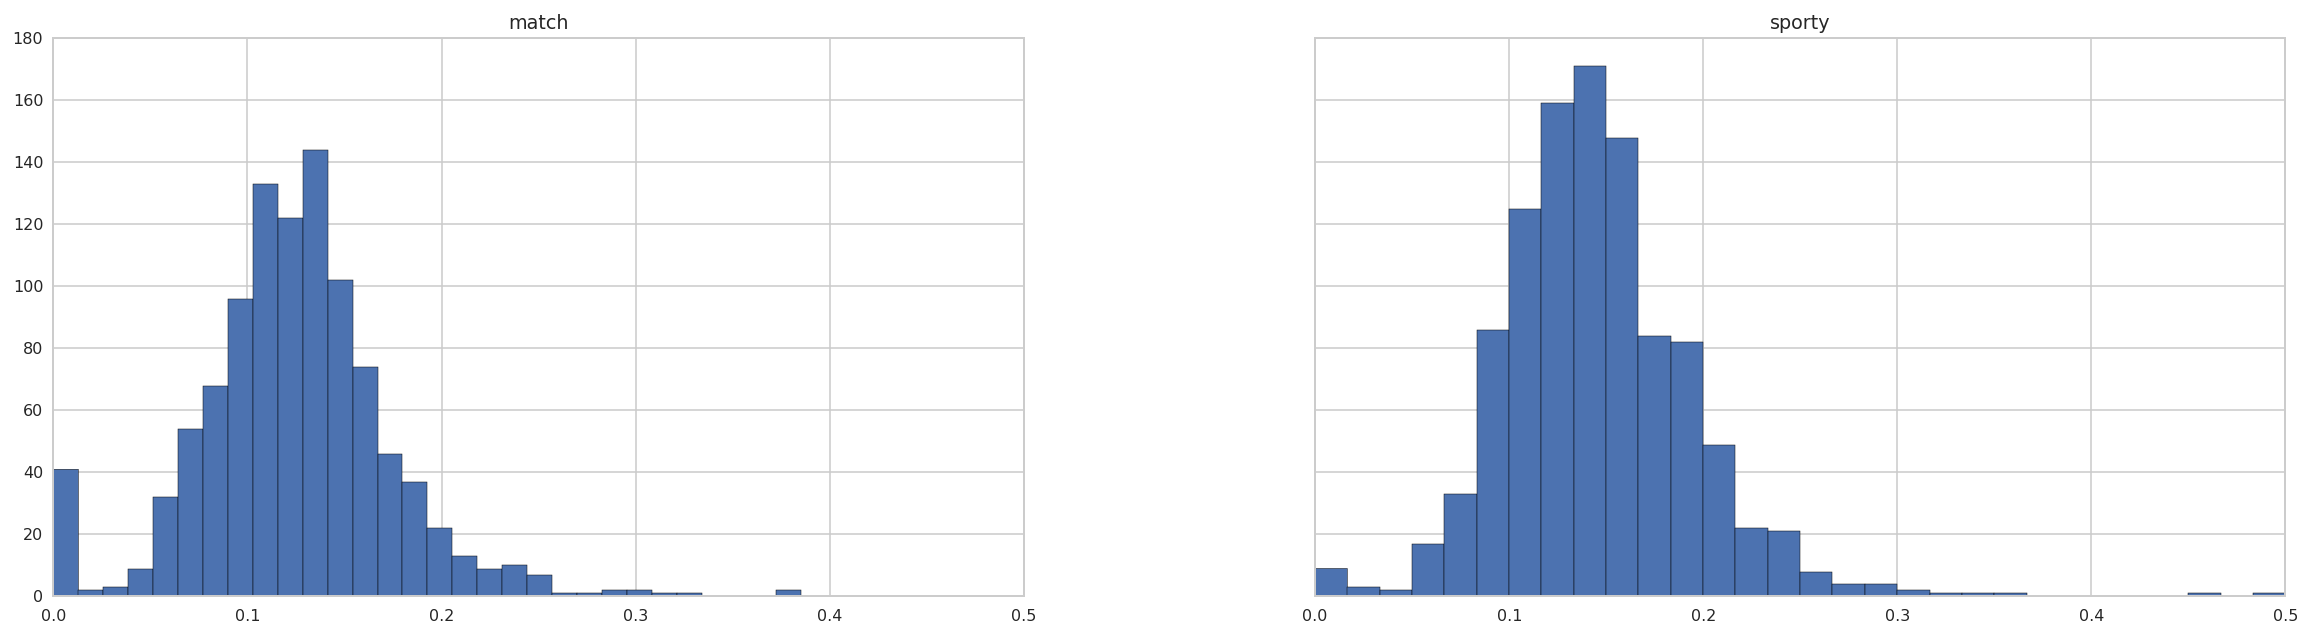

In [855]:
wn_fractions_df = pd.DataFrame([
        n_users['wn_fraction_food'].apply(lambda _: np.mean(_) if _ else 0),
        s_users['wn_fraction_food'].apply(lambda _: np.mean(_) if _ else 0)
    ],
                               index=['match', 'sporty']).T
axes = wn_fractions_df.hist(alpha=1, bins=30, figsize=(20,5), sharey=True, sharex=True)

In [856]:
def filter_out_wn_ratio(row, thresh):
    return [tw for tw, ratio in zip(row.food_tweets, row.wn_fraction_food) if ratio >= thresh]

ratio_thresh = 0.1
count_thresh = 10
n_users['food_tweets_filtered'] = n_users.apply(lambda _: filter_out_wn_ratio(_, ratio_thresh), axis=1)
s_users['food_tweets_filtered'] = s_users.apply(lambda _: filter_out_wn_ratio(_, ratio_thresh), axis=1)

keep_idx = ((n_users.food_tweets_filtered.apply(len) > count_thresh) & (s_users.food_tweets_filtered.apply(len) > count_thresh))
print("Keeping tweets with a score of at least %.2f and users with at least %d remaining tweets." % (ratio_thresh, count_thresh))
print("Yield %d users per group." % keep_idx.sum())

Keeping tweets with a score of at least 0.10 and users with at least 10 remaining tweets.
Yield 628 users per group.


In [857]:
print("%d tweets in the control group." % n_users[keep_idx].food_tweets.apply(len).sum())
print("%d tweets in the treatment group." % s_users[keep_idx].food_tweets.apply(len).sum())

64141 tweets in the control group.
71239 tweets in the treatment group.


#### K-means clustering

In [858]:
stopwords_punc = pd.read_csv("./stopwords_punc", header=None, names=['word']).word.tolist()
stopwords_punc += [_.replace("'", "’") for _ in stopwords_punc]
all_food_tweets_filtered = n_users.food_tweets_filtered[keep_idx].append(s_users.food_tweets_filtered[keep_idx])

vec_n, features_n, X_n, kmeans_n, kmeans_top_fts_n = cluster_users_tweets(n_users, n_users.food_tweets_filtered[keep_idx], n_clusters=10, max_iter=300, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False, ))
vec_s, features_s, X_s, kmeans_s, kmeans_top_fts_s = cluster_users_tweets(s_users, s_users.food_tweets_filtered[keep_idx], n_clusters=10, max_iter=300, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False))
vec_a, features_a, X_a, kmeans_a, kmeans_top_fts_a = cluster_users_tweets(None, all_food_tweets_filtered, n_clusters=10, max_iter=300, n_words=1000, stop_words=stopwords_punc,
                                                                          tokenize_kwargs=dict(keep_hashtags=False, keep_mentions=False, keep_urls=False, bigrams=False, liwc=False))

Vectorize data...
Done in 0.69s.
7235 features.
Run KMeans clustering...
Done in 8.11s.
Vectorize data...
Done in 0.74s.
7842 features.
Run KMeans clustering...
Done in 4.37s.
Vectorize data...
Done in 1.35s.
11705 features.
Run KMeans clustering...
Done in 23.27s.


In [859]:
kmeans_top_fts_a[:10]

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
0,river,unlocked,jam,eat,number,chicken,tomato,fish,ale,pumpkin
1,wine,badge,pizza,like,water,pizza,salad,like,ipa,number
2,party,shops,water,know,pizza,number,veggies,eat,brewing,water
3,beer,reached,food,good,coffee,just,bread,now,connoisseur,coffee
4,tea,checked,protection,butter,chicken,like,made,coffee,earned,park
5,shell,checking,next,just,beer,good,spinach,just,pale,eat
6,dark,porky”,world,cheese,just,love,red,good,stout,milk
7,today,different,coffee,chocolate,chocolate,bacon,garlic,cream,porter,beer
8,flavor,level,just,beer,cheese,turkey,baked,food,badge,just
9,number,caramba,beef,right,good,coffee,rice,day,rye,really


#### LDA topics 

In [860]:
from sklearn.decomposition import LatentDirichletAllocation

def print_top_words(model, feature_names, n_top_words):
    df = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        df['topic_%d' % topic_idx] = feature_names[topic.argsort()[::-1]][:n_top_words]
    return df

lda = LatentDirichletAllocation(n_topics=10, max_iter=30,
                            learning_method='online', 
                            learning_offset=3.,
                            random_state=0)

In [861]:
lda.fit(X_a)
print_top_words(lda, features_a, 10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,show,eh,coffee,late,chocolate,ice,sprint,number,prevent,great
1,spread,packers,number,dripping,now,numbernd,via,coffee,foundation,restaurant
2,say,filled,cake,luck,tools,checking,drupal,just,damage,wine
3,people,put,beer,cedar,city,snow,javascript,pizza,water,drive
4,makes,leave,pizza,numberpm,love,around,playlist,water,go,cheese
5,dollar,potato,just,leading,egg,made,food,chicken,beer,pumpkin
6,words,fondue,water,half,chicken,mayor,bay,good,another,turkey
7,type,melatonin,unlocked,travis,buffalo,start,user,beer,good,house
8,ok,insert,need,eat,workin,taco,deviled,like,emoticonsmile,beer
9,yummm,running,brisket,grilled,drink,spicy,bagel,cheese,food,number


## Find most discriminative features

In [862]:
# vectorized tweets
X_a
# create label
users_per_group = keep_idx.sum()
y_a = np.zeros((2*users_per_group))
y_a[users_per_group:] = 1

# debug classes
g = n_users.gender[keep_idx].as_matrix()
g = np.hstack([g,g])

In [863]:
X_af, y_af = X_a[g == 'f'], y_a[g == 'f']
X_am, y_am = X_a[g == 'm'], y_a[g == 'm']

### Classifier 

In [1156]:
def most_discrim_lr(X,y,features,n):
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X,y)
    sorted_idx = clf.coef_[0].argsort()
    df = pd.DataFrame()

    # for class 0
    df['match'] = features[sorted_idx][:n]
    df['coef_match'] = clf.coef_[0][sorted_idx][:n]
    df['is_food_match'] = df.match.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    
    # for positive class
    df['sporty'] = features[sorted_idx][::-1][:n]
    df['coef_sporty'] = clf.coef_[0][sorted_idx][::-1][:n]
    df['is_food_sporty'] = df.sporty.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    return df

def most_discrim_svm(X,y,features,n):
    clf = SVC(class_weight='balanced', kernel='linear')
    clf.fit(X,y)
    coefs = clf.coef_.toarray()[0]
    sorted_idx = coefs.argsort()
    df = pd.DataFrame()

    # for class 0
    df['match'] = features[sorted_idx][:n]
    df['coef_match'] = coefs[sorted_idx][:n]
    df['is_food_match'] = df.match.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    
    # for positive class
    df['sporty'] = features[sorted_idx][::-1][:n]
    df['coef_sporty'] = coefs[sorted_idx][::-1][:n]
    df['is_food_sporty'] = df.sporty.apply(lambda _: dp_food_words[_] if _ in dp_food_words else None)
    return df

In [865]:
t = most_discrim_lr(X_a, y_a, features_a, 2000)
# print(t[['match','sporty']].head(10).T.to_latex())
t.head(10)

,match,coef_match,is_food_match,sporty,coef_sporty,is_food_sporty
0,king,-0.681337,False,cafe,0.978429,False
1,last,-0.606627,False,photo,0.825530,False
2,gin,-0.589667,True,yogurt,0.811885,True
3,fun,-0.583955,False,starbucks,0.796388,False
4,everyone,-0.557046,False,pic,0.752356,False
5,play,-0.549079,False,broccoli,0.742775,True
6,event,-0.548889,False,badge,0.735423,False
7,friends,-0.546235,False,beach,0.732696,False
8,take,-0.527163,False,tree,0.722446,False
9,spread,-0.522870,True,tea,0.699508,True


In [881]:
tn = t[(t.is_food_match == True)][["match", "coef_match"]]
ts = t[(t.is_food_sporty == True)][["sporty","coef_sporty"]]
display(tn.head(10))
display(ts.head(10))

# LaTeX output
# tn.index += 1
# print(tn[['match']][:10].to_latex())
# ts.index += 1
# print(ts[['sporty']][:20].to_latex())

,match,coef_match
2,gin,-0.589667
9,spread,-0.522870
14,celery,-0.500799
16,peaches,-0.499155
26,treat,-0.467968
27,pickles,-0.466125
34,mozzarella,-0.438722
49,smoked,-0.395273
80,cocktails,-0.340810
85,cheddar,-0.333932


,sporty,coef_sporty
2,yogurt,0.811885
5,broccoli,0.742775
9,tea,0.699508
11,dinner,0.674488
13,burrito,0.662585
17,bean,0.600716
27,asparagus,0.563607
28,ale,0.561933
30,beans,0.558755
31,lunch,0.555931


#### Break down by gender

In [867]:
tf = most_discrim_lr(X_af, y_af, features_a, 2000)
tm = most_discrim_lr(X_am, y_am, features_a, 2000)

Female

In [868]:
tf_food_n = tf[tf.is_food_match][['match','coef_match']]
tf_food_s = tf[tf.is_food_sporty][['sporty','coef_sporty']]
display(tf_food_n.head(10))
display(tf_food_s.head(10))

,match,coef_match
1,watermelon,-0.323851
20,gin,-0.261876
22,pickles,-0.248753
35,okra,-0.224932
38,muffin,-0.219263
46,crab,-0.211745
49,chilly,-0.208661
51,sauces,-0.206499
64,veggie,-0.196337
72,whiskey,-0.193098


,sporty,coef_sporty
4,bean,0.377088
8,broccoli,0.334963
12,kale,0.325300
14,flatbread,0.324468
19,carrot,0.315530
25,goose,0.294502
27,greens,0.291633
35,lunch,0.274930
38,curry,0.269555
41,rice,0.268447


Male

In [869]:
tm_food_n = tm[tm.is_food_match][['match','coef_match']]
tm_food_s = tm[tm.is_food_sporty][['sporty','coef_sporty']]
display(tm_food_n.head(10))
display(tm_food_s.head(10))

,match,coef_match
0,spread,-0.658857
4,celery,-0.487532
20,gin,-0.378259
32,beer,-0.356695
40,treat,-0.341168
43,mozzarella,-0.338681
46,cheddar,-0.335951
54,avocados,-0.320768
66,drank,-0.308905
68,sour,-0.308716


,sporty,coef_sporty
0,yogurt,0.726805
8,breakfast,0.591019
11,burrito,0.567096
13,beans,0.530546
16,tea,0.509161
17,pies,0.505340
19,crab,0.499705
22,asparagus,0.491014
25,dinner,0.480206
26,broccoli,0.475512


### Group by categories 

In [870]:
MATCH_COLOR  = MD_COLORS.indigo_500
SPORTY_COLOR = MD_COLORS.teal_200

In this section, we look at the food-related predictive features of each category and we associate a food category to each one of them.
We then look at the most important food categories for each user class.

In [882]:
tn['food_cat'] = tn.match.apply(lambda _: food_dict[_] if food_dict[_] else '')
ts['food_cat'] = ts.sporty.apply(lambda _: food_dict[_] if food_dict[_] else '')

tn['definition'] = tn.match.apply(lambda _: textblob.Word(_).define())
tn['definition'] = tn.definition.apply(lambda _: _[0] if _ else '')
ts['definition'] = ts.sporty.apply(lambda _: textblob.Word(_).define())
ts['definition'] = ts.definition.apply(lambda _: _[0] if _ else '')

In [883]:
def amount_detected_food_features(s, col='food_cat'):
    nfeats = s.shape[0]
    ndefined = (s[col] != "").sum()
    print("%d out of %d (%.2f%%) food features are associated with a category." % (ndefined, nfeats, 100*ndefined/nfeats))

amount_detected_food_features(tn)
amount_detected_food_features(ts)

61 out of 159 (38.36%) food features are associated with a category.
123 out of 231 (53.25%) food features are associated with a category.


From there, we manually annotated missing labels.

In [888]:
tn = pd.read_csv("./match_food_cat.csv", index_col=0).fillna('')
ts = pd.read_csv("./sporty_food_cat.csv", index_col=0).fillna('')

amount_detected_food_features(tn, 'food_cat')
amount_detected_food_features(ts, 'food_cat')

130 out of 159 (81.76%) food features are associated with a category.
199 out of 231 (86.15%) food features are associated with a category.


In [1269]:
def bar_hatch(df, ax):
    bars = ax.patches
    hatches = ''.join(h*len(df) for h in 'X ')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.legend(loc='upper right')

In [1270]:
tn_tokens = tn[['match', 'food_cat']]
tn_tokens = tn_tokens[tn_tokens.food_cat != '']
tn_tokens.columns = ['word', 'category']
ts_tokens = ts[['sporty', 'food_cat']]
ts_tokens = ts_tokens[ts_tokens.food_cat != '']
ts_tokens.columns = ['word', 'category']

food_cat_tokens = tn_tokens.append(ts_tokens)
food_cat_tokens.index = food_cat_tokens.word
food_cat_dict = food_cat_tokens['category'].to_dict()

del food_cat_tokens

In [1271]:
n_users['food_cat_tokens'] = n_users.food_tokens.progress_apply(lambda l: ["_".join(food_cat_dict[tk].split()) for tw in l for tk in tw if tk in food_cat_dict])
s_users['food_cat_tokens'] = s_users.food_tokens.progress_apply(lambda l: ["_".join(food_cat_dict[tk].split()) for tw in l for tk in tw if tk in food_cat_dict])

#### Display most predictive food categories

In [1272]:
def plot_category_importance(xlim=None, gender=None):
    vec_cat = CountVectorizer(binary=True)
    
    n_users_idx = np.ones((n_users.shape[0])).astype(bool) if gender is None else n_users.gender == gender
    s_users_idx = np.ones((s_users.shape[0])).astype(bool) if gender is None else s_users.gender == gender
    
    n_food_cat_tokens = n_users[n_users_idx].food_cat_tokens
    s_food_cat_tokens = s_users[s_users_idx].food_cat_tokens
    all_food_cat_tokens = n_food_cat_tokens.append(s_food_cat_tokens).apply(lambda _: " ".join(_))
    
    X_cat = vec_cat.fit_transform(all_food_cat_tokens)
        
    features_cat = np.array(vec_cat.get_feature_names())
    y_cat = np.array([0]*n_food_cat_tokens.shape[0] + [1]*s_food_cat_tokens.shape[0])
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_cat, y_cat)
    
    sorted_idx = np.argsort(clf.coef_[0])
    
    fig, ax = plt.subplots(figsize=(5,10))
    
    pos    = np.arange(len(sorted_idx))
    labels = features_cat[sorted_idx]
    coefs  = clf.coef_[0][sorted_idx]
    
    idx_n = np.where(coefs < 0)[0]
    idx_s = np.where(coefs >= 0)[0]
    
    rects_n = ax.barh(pos[idx_n], coefs[idx_n], fc=MATCH_COLOR, ec='k', lw=1, align='center')
    rects_s = ax.barh(pos[idx_s], coefs[idx_s], fc=SPORTY_COLOR, ec='k', lw=1, align='center')

    rects = rects_n + rects_s#ax.barh(pos, coefs, fc=MD_COLORS.blue_700, ec=MD_COLORS.blue_900, lw=1, align='center')
        
    for l, r, c in zip(labels, rects, coefs):
        width = r.get_width()
        eps =.01
        
        if (c < 0):
            xloc = - width - eps
            align = 'right'
        else:
            xloc = width + eps
            align = 'left'
        
        yloc = r.get_y() + r.get_height()/2.0
        pretty_l = "\n".join(l.split("_")).capitalize()
        label = ax.text(xloc, yloc, pretty_l, horizontalalignment=align,
                        verticalalignment='center', color='k',
                        clip_on=True, fontdict=dict(size=7))
        
    ax.set_ylim([-1,len(sorted_idx)])
    if xlim:
        ax.set_xlim(xlim)
    ax.vlines(0,*ax.get_ylim())
    ax.set_yticks([])
    ax.grid(True, which='minor')
    ax.minorticks_on()
    
    handles = [rects_n[0], rects_s[0]]
    labels = ['match', 'sporty']
    ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()

All users

/home/virgile/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


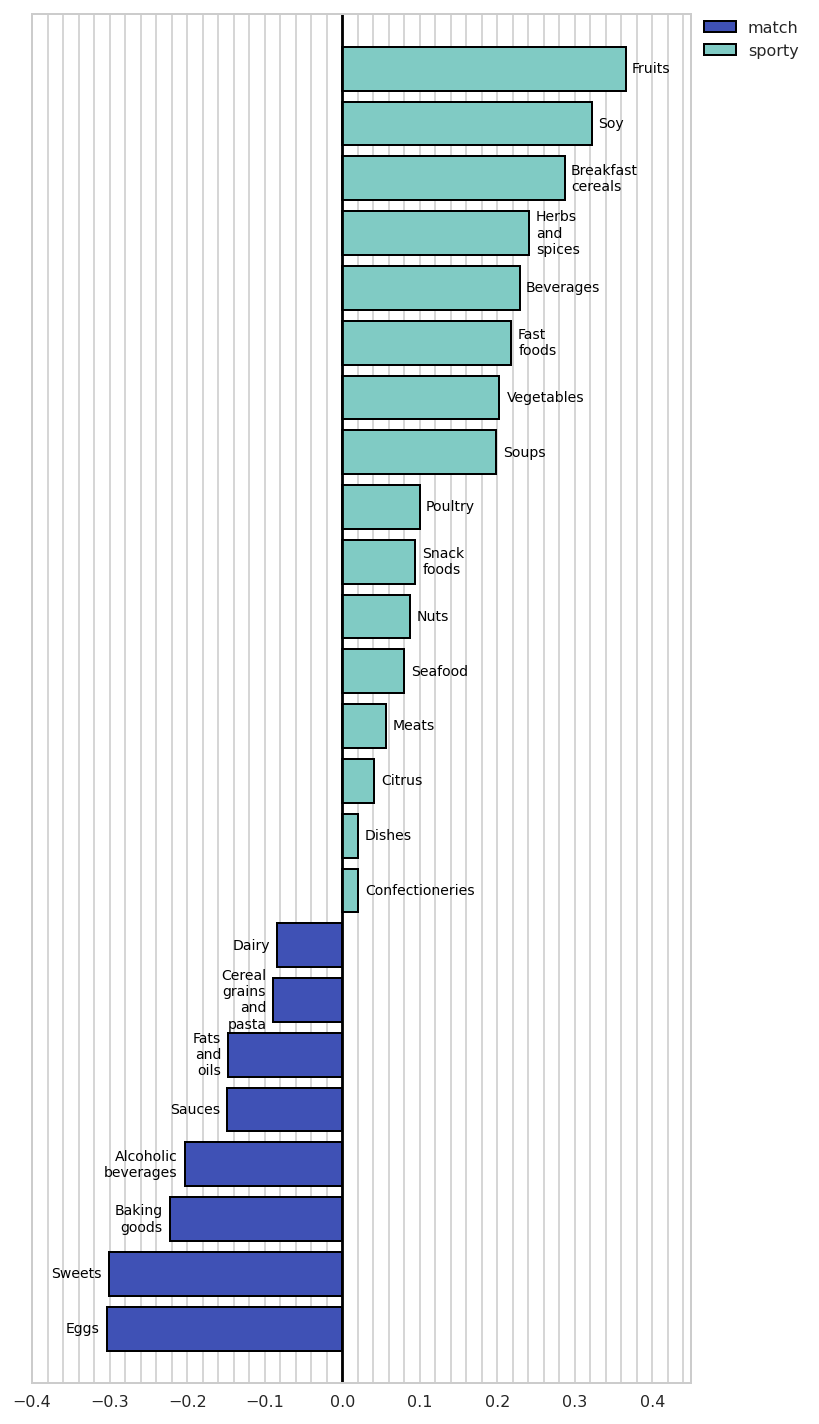

In [1273]:
plot_category_importance(xlim=[-.4,.45])

Female

/home/virgile/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


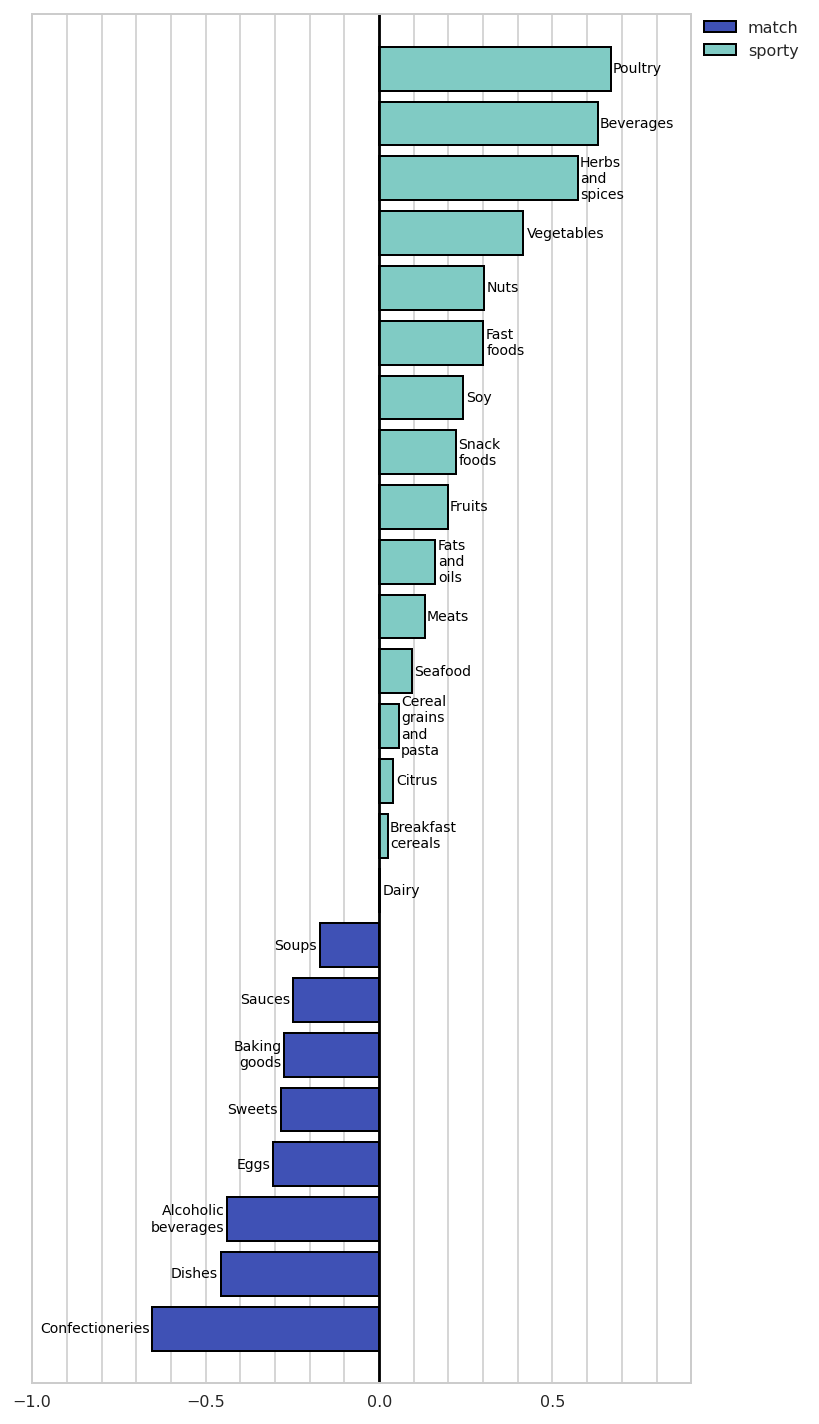

In [1279]:
plot_category_importance(gender='f', xlim=[-1,.9])

Male

/home/virgile/.local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


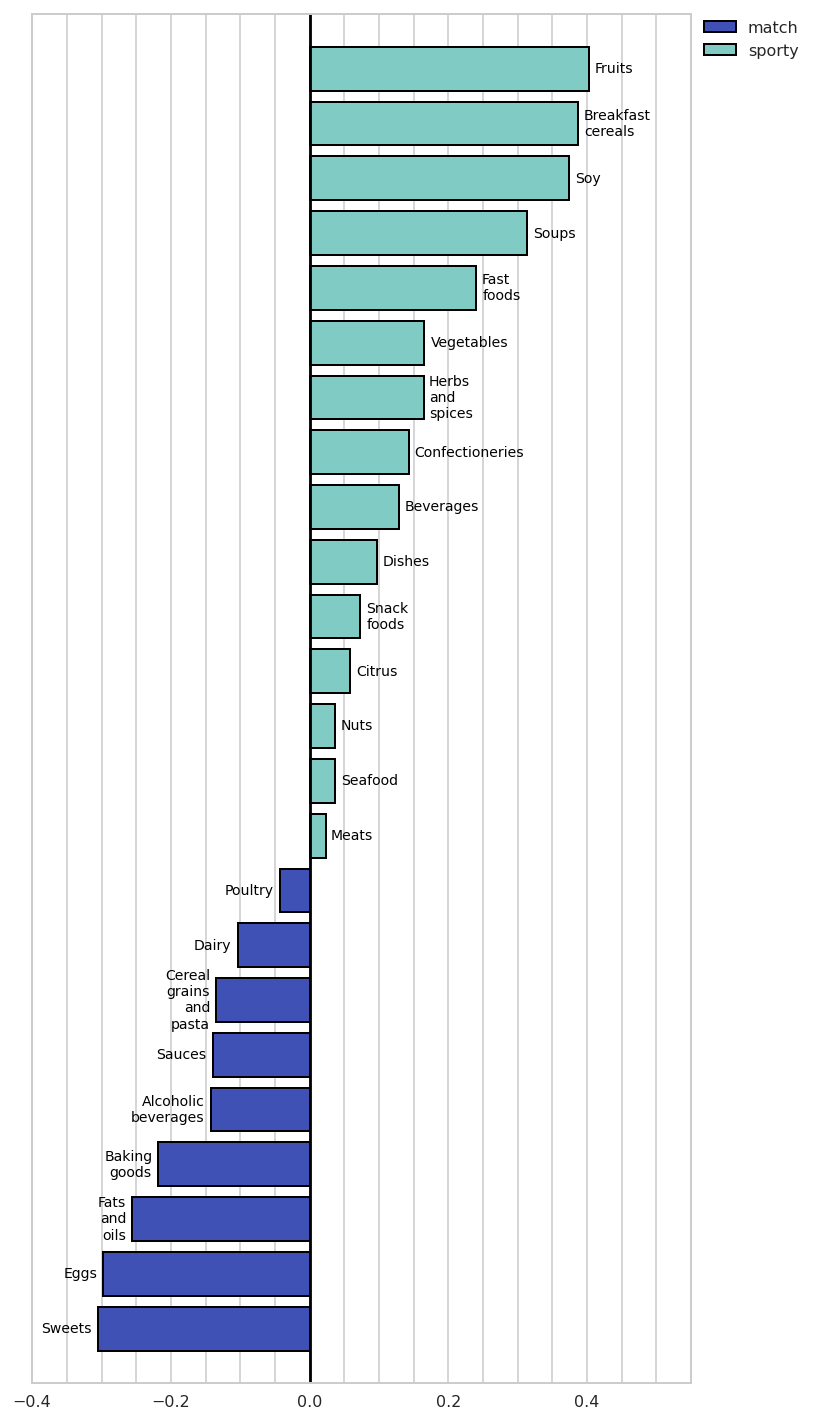

In [1275]:
plot_category_importance(gender='m', xlim=[-.4,.55])

#### Display percentage of food tweets mentioning a food category at the user level.

In [2072]:
def plot_category_user_distrib():
    """
    Plot the percentage of users mentioning at least one element in a food category
    for all food categories and for both classes.
    """
    vec_cat = CountVectorizer(binary=False)
    vec_cat.fit(n_users.food_cat_tokens.append(s_users.food_cat_tokens).apply(lambda _: " ".join(_)))
    features_cat = np.array(vec_cat.get_feature_names())
    
    def map_vecs(X, label):
        data = []
        for row in X.toarray():
            for ft, count in zip(features_cat, row):
                perc = count/row.sum()
                data.append({"food_cat": ft, "number": perc, "label": label})
        return data
    
    X_n = vec_cat.transform(n_users.food_cat_tokens.apply(lambda _: " ".join(_)))
    df_n = pd.DataFrame(map_vecs(X_n, 'match'))
    
    X_s = vec_cat.transform(s_users.food_cat_tokens.apply(lambda _: " ".join(_)))
    df_s = pd.DataFrame(map_vecs(X_s, 'sporty'))
    
    df = df_n.append(df_s)
    df.index = range(df.shape[0])
    
    fig, ax = plt.subplots(figsize=(10,5))
    sorted_x = df.groupby("food_cat").sum().sort_values("number").index[::-1].tolist()
    sorted_x = sorted_x[:10]
    keep_cats = set(sorted_x)
    
    df = df[df.food_cat.apply(lambda _: True if _ in keep_cats else False)]
    sns.boxplot(whis=0,
        x='food_cat', y='number', hue='label', data=df, palette=[MATCH_COLOR, SPORTY_COLOR],
        ax=ax, showfliers=False, width=.5, order=sorted_x,
        showmeans=True, meanprops=dict(marker='o', markeredgecolor='k', markerfacecolor=(0,0,0,.8))
    )
    
    xticklabels = []
    for xlabel in ax.get_xticklabels():
        txt = xlabel.get_text()
        txt = "\n".join(txt.split("_")).capitalize()
        rotation = 45
        xlabel.set_rotation(rotation)
        xticklabels.append(txt)
        
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel("Percentage of food tweets\nat the user level")
    ax.set_xlabel("Food category")
    ax.set_ylim([-.01,.23])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    return df

/home/virgile/.local/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in long_scalars


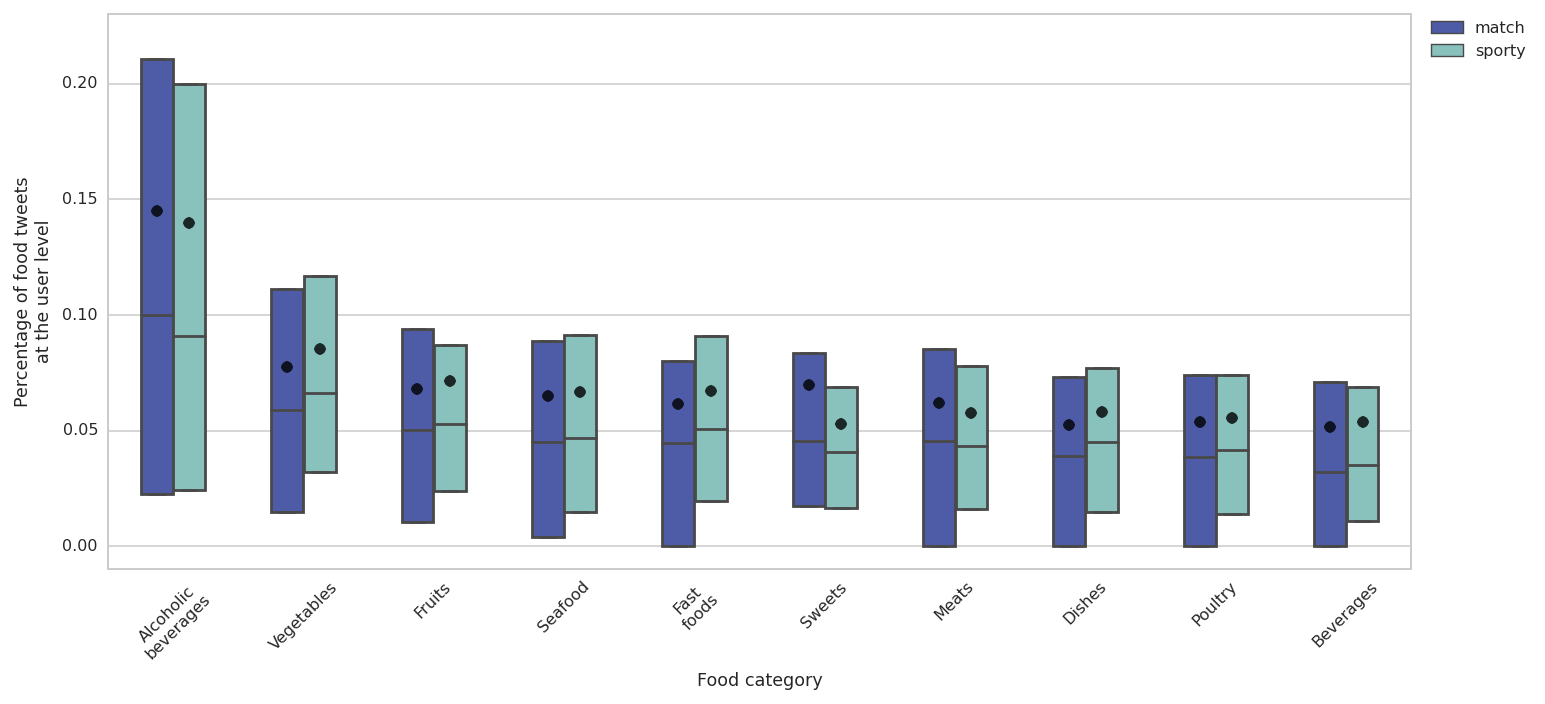

In [2073]:
df_food_cats = plot_category_user_distrib()

#### Print definitions of most predictive food tokens in each category

In [1278]:
def print_definitions():
    all_cats = list(set(tn.food_cat) | set(ts.food_cat))
    for c in all_cats:
        fc_n = tn[tn.food_cat == c]
        fc_s = ts[ts.food_cat == c]
        print("{} ({} in sporty and {} in match)".format(c.capitalize(), fc_s.shape[0], fc_n.shape[0]))
        for utype, fc in [('sporty', fc_s),('match', fc_n)]:
            print("- {}".format(utype))
    #         display(fc.head(10))
            for i, r in fc.head(10).iterrows():
                print("\t- {:<15}: {}{}".format(r[utype], r.definition[:120], "..." if len(r.definition) > 120 else ''))
        print("-"*100)

print_definitions()

 (31 in sporty and 29 in match)
- sporty
	- dinner         : the main meal of the day served in the evening or at midday
	- lunch          : a midday meal
	- breakfast      : the first meal of the day (usually in the morning)
	- supper         : a light evening meal; served in early evening if dinner is at midday or served late in the evening at bedtime
	- bitter         : English term for a dry sharp-tasting ale with strong flavor of hops (usually on draft)
	- subs           : a large sandwich made of a long crusty roll split lengthwise and filled with meats and cheese (and tomato and onion and ...
	- barley         : a grain of barley
	- vintage        : a season's yield of wine from a vineyard
	- provisions     : a stock or supply of foods
	- biscuit        : small round bread leavened with baking-powder or soda
- match
	- smoked         : inhale and exhale smoke from cigarettes, cigars, pipes
	- cookout        : an informal meal cooked and eaten outdoors
	- goodies        : somethi

## Load exemplars data 

### Collect list of people followed by each users 

In [1830]:
with open("twitterauth.json") as fd:
    creds = json.load(fd)

In [1831]:
import tweepy

auth = tweepy.OAuthHandler(creds['consumer_key'], creds['consumer_secret'])
auth.set_access_token(creds['access_token'], creds['access_token_secret'])
api = tweepy.API(auth)

In [1832]:
def collect_friends_ids(uid):
    p = "/data/1/sporty/users/friends_ids/%d" % uid
    file_missing = not os.path.exists(p)
    if file_missing or os.path.getsize(p) == 0:
        with open(p, 'w') as fd:
            try:
                l = api.friends_ids(id=uid)
                for fid in l:
                    fd.write("%d\n" % fid)
                time.sleep(60) # avoid reaching rate limit of 15 requests per 15 minute window
            except:
                time.sleep(60) # wait more because rate limit has been reached
                
# n_users[keep_idx].id.progress_apply(collect_friends_ids)
# s_users[keep_idx].id.progress_apply(collect_friends_ids)

In [73]:
def load_friends_list(uid):
    p = "/data/1/sporty/users/friends_ids/%d" % uid
    friends = []
    if os.path.exists(p):
        with open(p) as fd:
            for l in fd:
                friends.append(int(l.strip()))
    return friends
        
n_users['friends'] = n_users.id.apply(load_friends_list)
s_users['friends'] = s_users.id.apply(load_friends_list)

### Exemplars

In [74]:
exemplars_set = set(pd.read_csv("exemplars.txt", header=None)[0])

### Collect user informations for each nutrition-related handle

In [75]:
nutrition_handles_set = exemplars_set #| good_guides_set

In [76]:
# recipe to iterate over any iterable by chunks of n
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

### Loads ids of nutrition related accounts 

In [78]:
import glob

def load_nutrition_ids(re_path, limit_to=None):
    nutrition_uids = {}
    for p in glob.glob(re_path):
        with open(p) as fd:
            u = json.loads(fd.readline())
            if limit_to is None or u['screen_name'] in limit_to:
                nutrition_uids[u['screen_name']] = u['id']
    return nutrition_uids


exemplars_dict = load_nutrition_ids("/data/1/sporty/users/nutrition_users/*", exemplars_set)
exemplars_ids = set(exemplars_dict.values())

## Analyze food-related friends and mentions for each group 

### Build lists of nutrition friends

In [80]:
n_users['exemplar_friends'] = n_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in exemplars_ids])
s_users['exemplar_friends'] = s_users.friends.apply(lambda l: l if type(l) == float else [_ for _ in l if _ in exemplars_ids])

### Compare exemplar friends

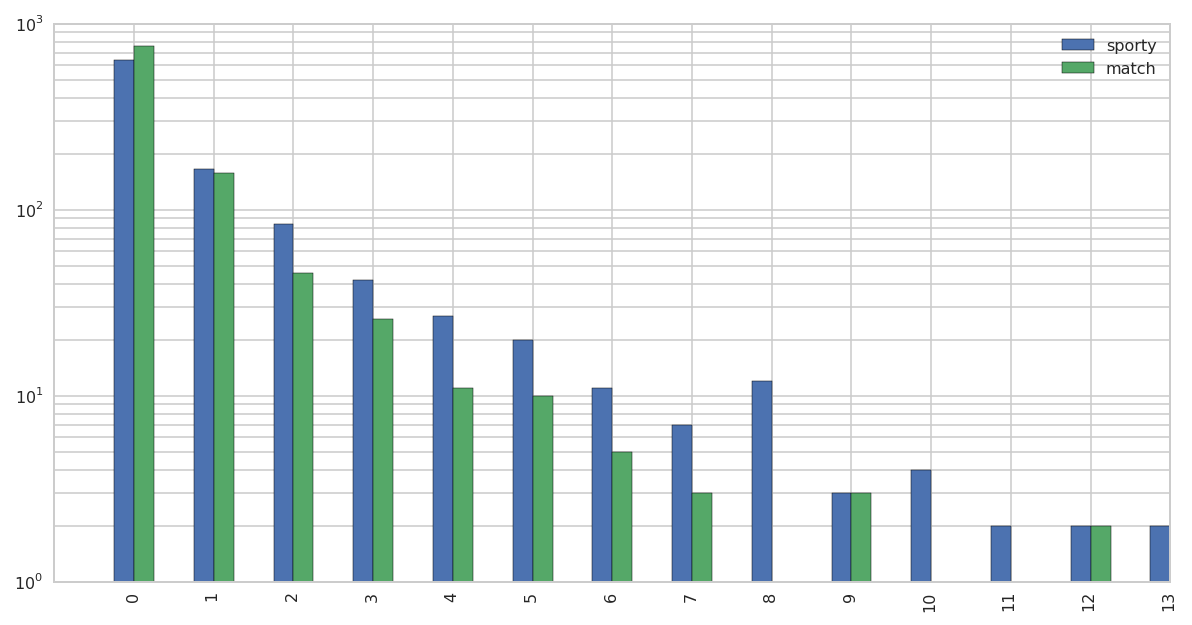

In [83]:
exemplars_friends_df = pd.DataFrame()
exemplars_friends_df['sporty'] = s_users.exemplar_friends.apply(lambda _: 0 if type(_) is float else len(_))
exemplars_friends_df['match']  = n_users.exemplar_friends.apply(lambda _: 0 if type(_) is float else len(_))

In [1826]:
def plot_smoothed_avg(df, window=100, xlabel=None, ylabel=None, remove_zeros=False):
    df_sporty = df[['sporty']]
    df_sporty.columns = ['friends_count']
    df_sporty['label'] = 1
    df_match = df[['match']]
    df_match.columns = ['friends_count']
    df_match['label'] = 0
    
    np.random.seed(111191)

    new_df = df_sporty.append(df_match, ignore_index=True)
    new_df = new_df.reindex(np.random.permutation(new_df.index))
    new_df = new_df.sort_values('friends_count', kind='quicksort')
    if remove_zeros:
        new_df = new_df[new_df.friends_count != 0]
    new_df.index = range(new_df.shape[0])
    new_df_rmean = new_df.rolling(window).mean()
    new_df_rmean.index = np.arange(new_df_rmean.shape[0])
    
    new_df_rmean['original_friends_count'] = new_df.friends_count
    new_df_rmean['original_label'] = new_df.label

    new_df_rmean.dropna(inplace=True)
    ax = new_df_rmean.plot(kind='line', x='friends_count', y='label')
    ax.set_ylabel(xlabel)
    ax.set_xlabel(ylabel)
    ax.legend_.remove()
    plt.tight_layout()


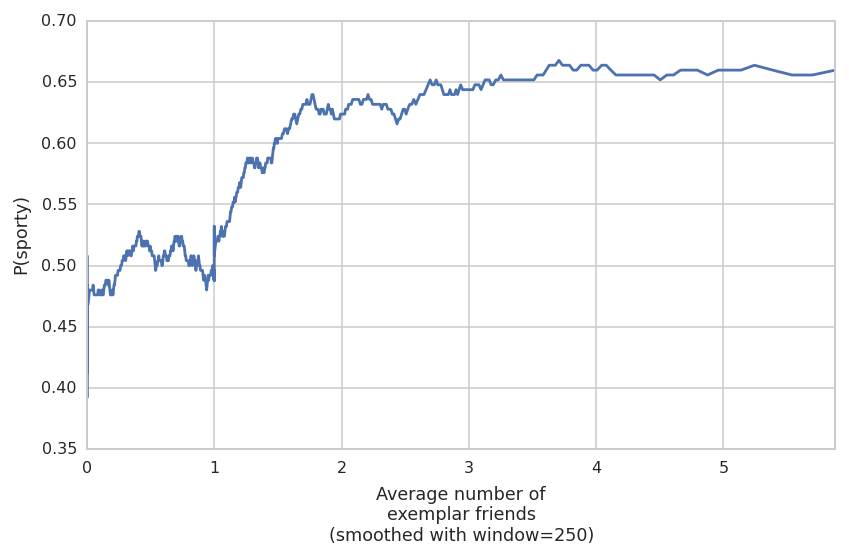

In [1827]:
wd = 250
plot_smoothed_avg(
    exemplars_friends_df, window=wd, remove_zeros=False,
    xlabel='P(sporty)', ylabel="Average number of\nexemplar friends\n(smoothed with window=%d)" % wd
)

### Filter mentions and simple count

In [1822]:
mentions_re = re.compile("^@[0-9a-z\-_]+")
mentions_set = set(["@" + _ for _ in exemplars_set])
nutrition_tokenize = lambda tw: tokenize(tw, collapse_mentions=False, bigrams=False, liwc=False, limit_repeats=False, keep_mentions=True)
n_users['exemplar_mentions'] = n_users.tweets.progress_apply(lambda l: [tk for tw in l for tk in tw.split()]).apply(lambda l: mentions_set & set(l))
s_users['exemplar_mentions'] = s_users.tweets.progress_apply(lambda l: [tk for tw in l for tk in tw.split()]).apply(lambda l: mentions_set & set(l))

n_users['exemplar_mentions_count'] = n_users.exemplar_mentions.apply(len)
s_users['exemplar_mentions_count'] = s_users.exemplar_mentions.apply(len)

In [1823]:
mentions_df = pd.DataFrame()
mentions_df['sporty'] = s_users.exemplar_mentions_count
mentions_df['match']  = n_users.exemplar_mentions_count

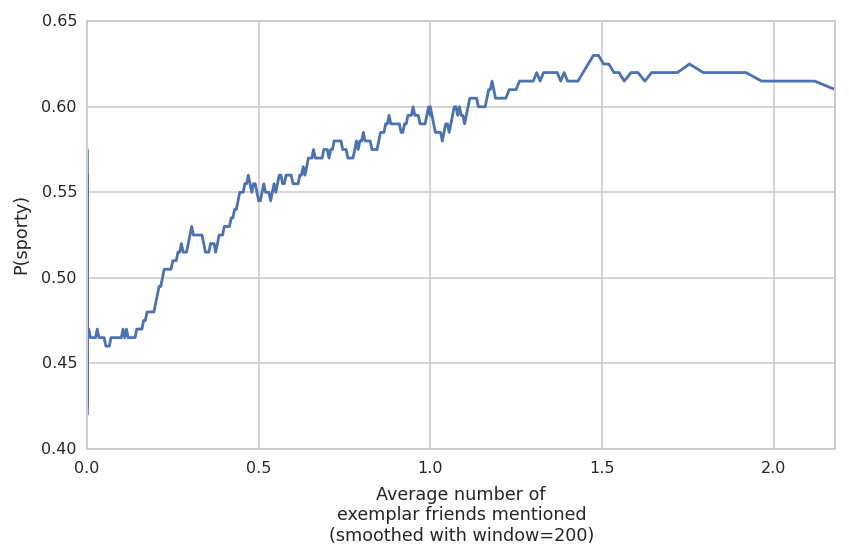

In [1829]:
wd = 200
plot_smoothed_avg(mentions_df, window=wd, remove_zeros=False,
                  xlabel='P(sporty)', ylabel="Average number of\nexemplar friends mentioned\n(smoothed with window=%d)" % wd)

### Both friends and mentions

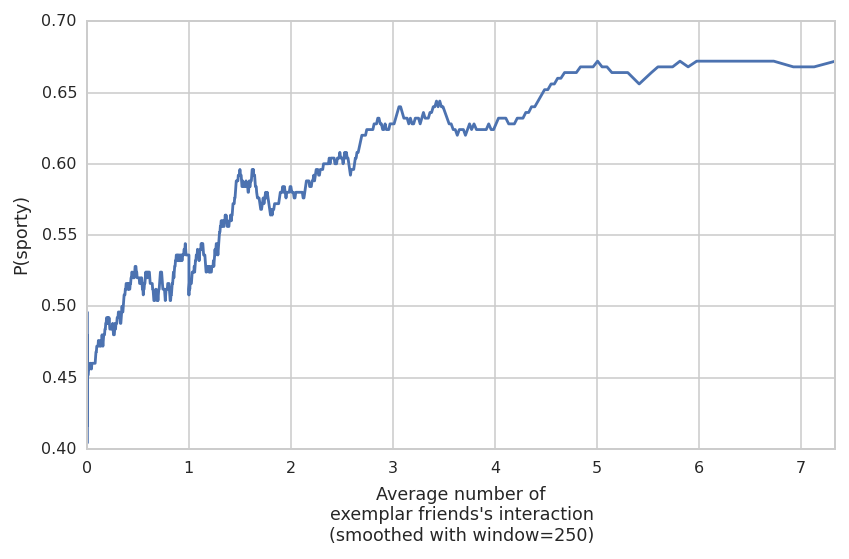

In [2085]:
wd = 250
plot_smoothed_avg(mentions_df + exemplars_friends_df, window=wd, remove_zeros=False,
                  xlabel='P(sporty)', ylabel="Average number of\nexemplar friends's interaction\n(smoothed with window=%d)" % wd)

## Train on food features only

In [2113]:
labeled_food_set = set(tn.match.append(ts.sporty))
def keep_food_vocab(l):
    return list( set([w for tw in l for w in tw.split()]) & labeled_food_set)

def keep_food_lexicon(l):
    return list( set([w for tw in l for w in tw.split()]) & set(foodb_words | weber_lexicon) - exclude_words )

n_users['food_vocab'] = n_users.food_tweets.apply(keep_food_vocab)
s_users['food_vocab'] = s_users.food_tweets.apply(keep_food_vocab)

n_users['food_lexicon_vocab'] = n_users.food_tweets.apply(keep_food_lexicon)
s_users['food_lexicon_vocab'] = s_users.food_tweets.apply(keep_food_lexicon)

n_users['exemplar_friends_count'] = n_users.exemplar_friends.apply(len)
s_users['exemplar_friends_count'] = s_users.exemplar_friends.apply(len)

n_users['exemplar_interactions_count'] = n_users.exemplar_friends_count + n_users.exemplar_mentions_count
s_users['exemplar_interactions_count'] = s_users.exemplar_friends_count + s_users.exemplar_mentions_count

In [2155]:
data = n_users.append(s_users)[['food_vocab', 'food_lexicon_vocab', 'food_cat_tokens',
                                'exemplar_friends_count', 'exemplar_mentions_count',
                                'exemplar_interactions_count'
                               ]]
data['reference'] = n_users.index.append(s_users.index)
labels = np.array([0]*n_users.shape[0] + [1]*s_users.shape[0])

keep_data_idx = data.food_vocab.apply(len) > 20
# keep_data_idx = data.food_lexicon_vocab.apply(len) > 50

data = data[keep_data_idx]
labels = labels[keep_data_idx]

text_features = ['food_vocab', 'food_cat_tokens'] #, 'food_lexicon_vocab'
int_features = ['exemplar_mentions_count'] #'exemplar_interactions_count', 'exemplar_friends_count', 
all_features = text_features + int_features
all_combinations = []
for i in range(1, len(all_features)+1):
    all_combinations.extend(it.combinations(all_features, i))

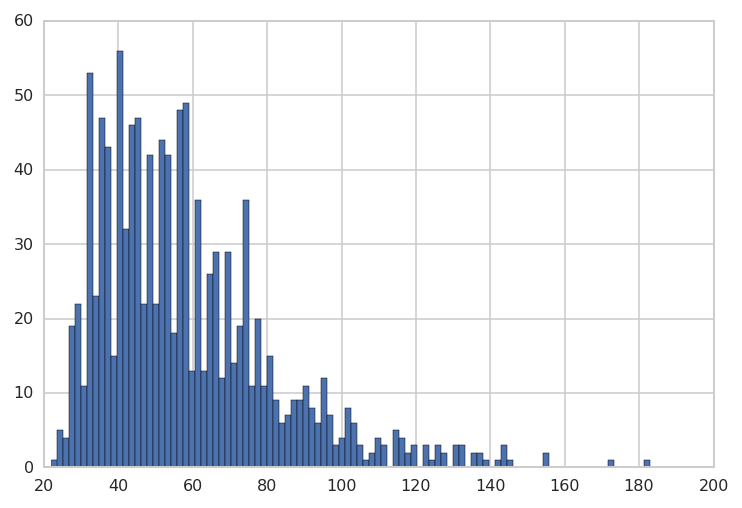

In [2156]:
data.food_lexicon_vocab.apply(lambda _: len(_)).hist(bins=100)

### Run 10-fold cross validation with LR model

In [2157]:
def display_cv_results(results_dict, key):
    title = "Features: " + " + ".join(key)
    print(title)
    print("-"*len(title))
    r = results_dict[key]
    
    y_trues  = []
    y_scores = []
    y_preds  = []
    for f in r:
        y_trues += f['y_true']
        y_scores += f['y_score']
        y_preds  += f['y_pred']
    fpr, tpr, thresh = metrics.roc_curve(y_trues, y_scores)
    
    fig, ax = plt.subplots()
    ax.scatter(fpr, tpr, marker='x', linestyle='-')
    ax.plot([0,1],[0,1],color='k',linestyle='--')
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    print(metrics.classification_report(np.array(y_trues), np.array(y_preds), target_names=['match', 'sporty'], digits=4))
    print("="*100)
    print()

In [2295]:
def cv_food(data, labels, text_features, int_features=None,
            n_folds=10, seed=111191, thresh=.5):
    # build features matrix
    vec = TfidfVectorizer(binary=True, min_df=3, max_df=.95)

    # encode and add text features
    text_data = data.apply(lambda r: sum([r[c] for c in text_features], []), axis=1).apply(lambda _: " ".join(_))
    X = vec.fit_transform(text_data)
    features = vec.get_feature_names()
    
    # encode int features if needed
    if int_features:
        int_data = []
        for c in int_features:
            c_data = []
            data[c].apply(lambda _: c_data.append(_))
            int_data.append(c_data)
        int_data = sp.csr_matrix(int_data).T
        X = sp.hstack([X,int_data])
        features += int_features
    
#     X = preprocessing.scale(X.toarray())
    X = sp.csr_matrix(X)
    features = np.array(features)

    # build cv
    results = []
    for i, (tr, te) in enumerate(KFold(X.shape[0], n_folds, shuffle=True, random_state=seed)):
        # create training/testing sets
        X_tr, y_tr = X[tr], labels[tr]
        X_te, y_te = X[te], labels[te]
        # build classifier, fit on training data and predict on testing data
        clf = LogisticRegression(class_weight='balanced', penalty='l2', C=.2, max_iter=200)
        clf.fit(X_tr, y_tr)
        y_prob = clf.predict_proba(X_te)
        if thresh != .5:
            y_pred = (y_prob[:, 1] > thresh).astype(int)
        else:
            y_pred = clf.predict(X_te)
        # save results
        fold_res = dict(fold=i)
        fold_res['y_true']  = y_te.tolist()
        fold_res['y_score'] = y_prob[:,1].tolist()
        fold_res['y_pred']  = y_pred.tolist()
        fold_res['references'] = data.iloc[te].reference
        fold_res['indices'] = te
        results.append(fold_res)
        
    return results

### Display results


Features: food_cat_tokens
-------------------------
             precision    recall  f1-score   support

      match     0.4632    0.5420    0.4995       500
     sporty     0.5989    0.5213    0.5575       656

avg / total     0.5403    0.5303    0.5324      1156


Features: food_vocab
--------------------
             precision    recall  f1-score   support

      match     0.5395    0.5600    0.5496       500
     sporty     0.6546    0.6357    0.6450       656

avg / total     0.6048    0.6029    0.6037      1156


Features: food_cat_tokens + exemplar_mentions_count
---------------------------------------------------
             precision    recall  f1-score   support

      match     0.4670    0.5520    0.5060       500
     sporty     0.6035    0.5198    0.5586       656

avg / total     0.5445    0.5337    0.5358      1156


Features: food_vocab + exemplar_mentions_count
----------------------------------------------
             precision    recall  f1-score   support

     

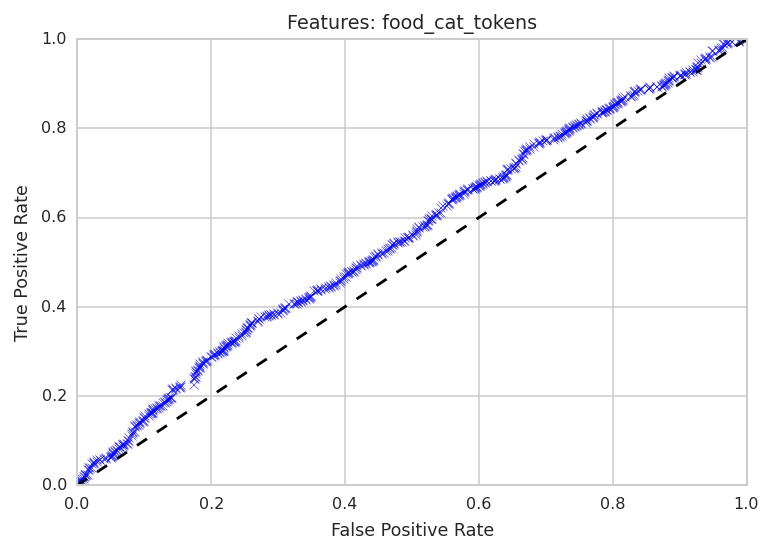

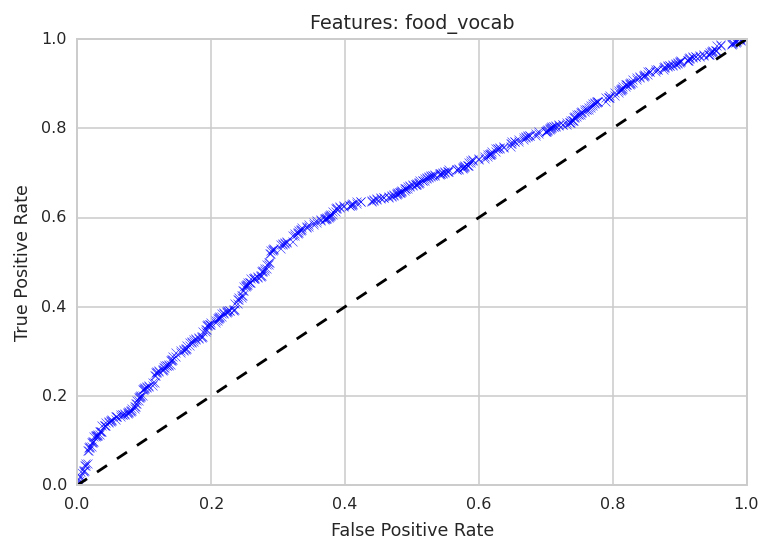

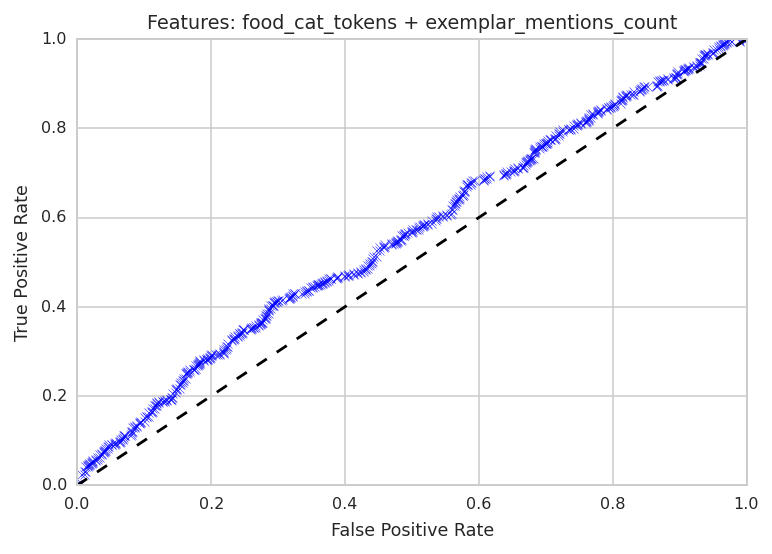

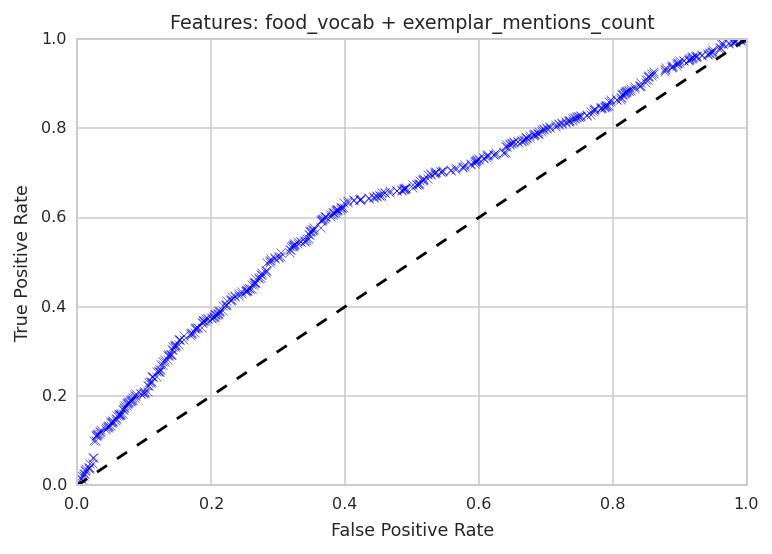

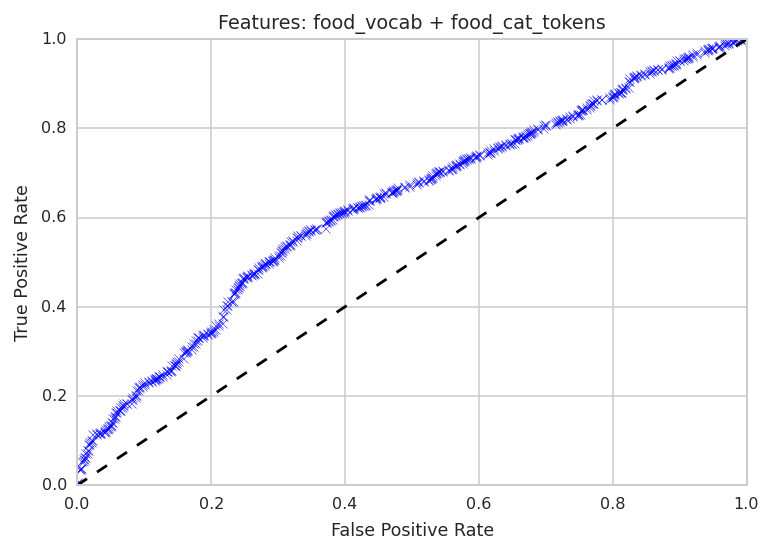

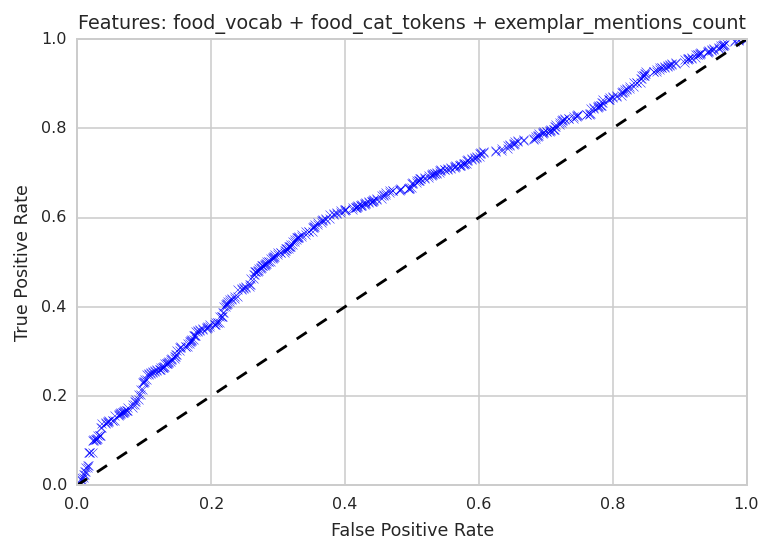

In [2301]:
# results_cv = {}
for comb in tqdm_notebook(all_combinations):
    textf = set(text_features) & set(comb)
    intf  = set(int_features)  & set(comb)
    if textf:
        results_cv[comb] = cv_food(data, labels, textf, intf)
        
for k in sorted(results_cv.keys(), key=len):
    display_cv_results(results_cv, k)

### Study misclassified data

In [2302]:
best_features = ('food_vocab', 'food_cat_tokens', 'exemplar_mentions_count')

In [2303]:
classification_details = []
for fold in results_cv[best_features]:
    fold_m = [(r, t, pro, pre, i) for r, t, pro, pre, i in zip(fold['references'], fold['y_true'], fold['y_score'], fold['y_pred'], fold['indices'])]
    classification_details.extend(fold_m)

misclassified = [_ for _ in classification_details if _[1] != _[3]]

In [2304]:
misclassified_p1t0 = [_ for _ in misclassified if _[1] == 0]

In [2305]:
most_misclassified = [_ for _ in sorted(misclassified_p1t0, reverse=True, key=lambda _:_[2])]

#### Tweets from matched users classified as sporty by our classifier based on food features.

In [2245]:
%%time

from sklearn.decomposition import PCA

def pca_sporty_match(n_components=10):
    vec = TfidfVectorizer(binary=True, stop_words='english', min_df=2, max_features=2000)
    all_tw = n_users.append(s_users).all_tw_tokenized
    all_tw = all_tw[keep_data_idx]
    
    X = vec.fit_transform(all_tw)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X.toarray())
    features = np.array(vec.get_feature_names())
    return X, X_pca, pca, features

X_all_tw, X_pca, pca, fts_pca = pca_sporty_match(n_components=10)

CPU times: user 29.4 s, sys: 51 ms, total: 29.4 s
Wall time: 29.5 s


In [2246]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.04119662,  0.06183627,  0.07472839,  0.08555677,  0.09598399,
        0.10336604,  0.10942808,  0.11476809,  0.12009839,  0.12468105])

In [2336]:
def print_most_misclassified():
    vec = TfidfVectorizer(binary=True, stop_words='english', min_df=2, max_features=2000)
    all_tw = n_users.append(s_users).all_tw_tokenized
    all_tw = all_tw[keep_data_idx]
    
    X = vec.fit_transform(all_tw)
    features = np.array(vec.get_feature_names())
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X, labels)
    coefs = clf.coef_[0]
    sorted_coef_idx = np.argsort(np.abs(coefs))[::-1]
    
    print("%d misclassified match users." % len(most_misclassified))
    for r, t, pro, pre, i in most_misclassified[:30]:
        print("Misclassified with confidence = %.2f" % pro)
        u = n_users.loc[r]
        X_i = X[i].toarray().reshape(-1,)
        
        weights = X_i*coefs
        top_idx = np.argsort(np.abs(weights))[::-1]
        
        for j in top_idx[:5]:
            f = features[j]
            w = weights[j]
            print("\t - {:<25}{:>3f}".format(f, w))
        
print_most_misclassified()

211 misclassified match users.
Misclassified with confidence = 0.78
	 - fitness                  0.052488
	 - workout                  0.037698
	 - mile                     0.037369
	 - gym                      0.034331
	 - burgers                  0.032833
Misclassified with confidence = 0.76
	 - pace                     0.050485
	 - mi                       0.046399
	 - fitness                  0.038972
	 - badge                    0.035320
	 - workout                  0.027991
Misclassified with confidence = 0.75
	 - pace                     0.051287
	 - mi                       0.047137
	 - fitness                  0.039592
	 - badge                    0.035881
	 - workout                  0.028436
Misclassified with confidence = 0.63
	 - fitness                  0.041323
	 - badge                    0.037450
	 - workout                  0.029679
	 - mile                     0.029420
	 - considered               -0.028494
Misclassified with confidence = 0.62
	 - fitness            

In [2365]:
t = n_users.tweets.progress_apply(lambda l: [tw for tw in l if set(["fitness", "workout", "exercise", "gym"]) & set(tw.lower().split())])

In [2366]:
t2 = t.apply(len).apply(lambda _: 10 if _ > 10 else _)

In [2367]:
t2[t2!=0].shape

(603,)

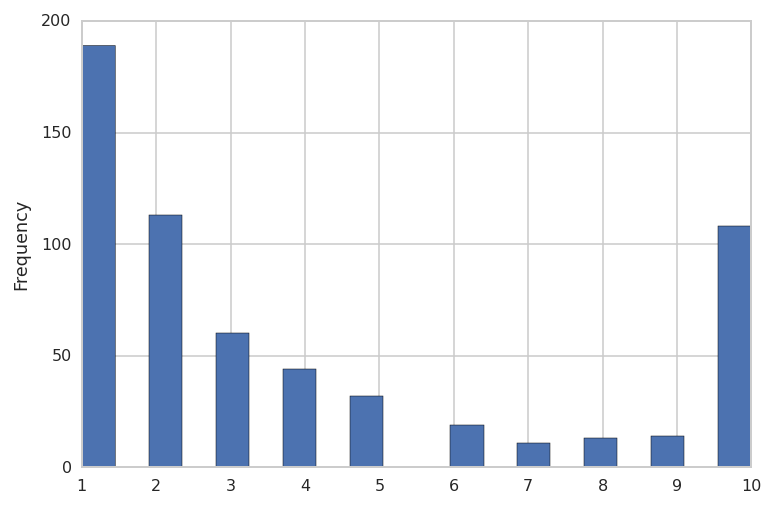

In [2368]:
t2[t2!=0].plot(kind='hist', bins=20)

In [2344]:
t.apply(lambda _: 1 if _ else 0).sum()

603

In [2339]:
t.shape

(1034,)

In [2335]:
t[:10].apply(lambda l: [print(tw) for tw in l[:10]]);

Ye olde kick drum foot: getting a good workout thanks to the new @ManchesterOrch record #COPE http://t.co/eI9yTXxl8X
@karenplusone Your rubber stamp is getting a workout today
Nothing better than walking home from a workout behind an early morning cigar smoker (at @QuickFitness16) http://t.co/p8PmOQpdXp
Hey @bad_robot: You want a "thirtysomething male, intellectual, no fitness requirement" for #starwars? Ahem. AHEM. http://t.co/upIJ1G6nvw
@christinamerge I feel like a Gagnam workout video is just around the corner....
Always a good exercise RT @ericacampbell: get ideas from top referring sources of traffic & destination urls (where r ppl going to) #aptchat


In [2254]:
def most_important_pca_fts():
    df = pd.DataFrame()
    n = 10
    for i, comp in enumerate(pca.components_):
        comp_idx = np.argsort(np.abs(comp))[::-1]
        comp_fts = [fts_pca[i] for i in comp_idx[:n]]
        comp_val = [comp[i] for i in comp_idx[:n]]

        df['PCA_%d_features' % (i+1)] = comp_fts
        df['PCA_%d_values' % (i+1)] = comp_val
    return df
most_important_pca_fts()

,PCA_1_features,PCA_1_values,PCA_2_features,PCA_2_values,PCA_3_features,PCA_3_values,PCA_4_features,PCA_4_values,PCA_5_features,PCA_5_values,PCA_6_features,PCA_6_values,PCA_7_features,PCA_7_values,PCA_8_features,PCA_8_values,PCA_9_features,PCA_9_values,PCA_10_features,PCA_10_values
0,accounts,-0.057435,software,0.086638,martin,0.089790,wtf,-0.114773,pumpkin,-0.086219,universe,-0.098820,medical,0.119674,fitness,0.147021,certainly,0.103075,mayor,-0.096438
1,file,-0.056771,user,0.082037,jones,0.086942,shit,-0.107139,sushi,-0.082854,pace,0.096269,exercise,0.111825,shit,0.105203,recipe,0.098103,gay,-0.096026
2,pages,-0.056207,users,0.081468,lee,0.084538,lessons,0.096373,unlocked,-0.081295,coach,0.094113,government,0.105325,gym,0.105191,tasty,0.095309,marriage,-0.095361
3,useful,-0.055194,launch,0.079218,mayor,0.083795,thankful,0.095418,yum,-0.080916,teams,0.088112,upcoming,-0.093576,ass,0.093804,com,-0.093565,employees,-0.093198
4,links,-0.054997,ios,0.076383,stadium,0.082992,gifts,0.094627,burgers,-0.080062,artist,-0.086954,rocking,-0.088889,improve,0.092462,waking,-0.090264,iron,0.091022
5,reviews,-0.054910,data,0.075646,jimmy,0.081084,inspiration,0.087811,tacos,-0.078855,sex,-0.086470,china,0.088687,products,0.092209,im,-0.088825,pure,0.080878
6,exist,-0.054485,features,0.075011,tony,0.080268,damn,-0.081847,pub,-0.078678,players,0.084967,tax,0.082459,ultimate,0.087033,daddy,-0.082926,ave,-0.080492
7,reference,-0.053679,crying,-0.074558,smith,0.079796,ass,-0.081428,badge,-0.078648,golf,0.080416,americans,0.081648,sexy,0.085283,depends,0.080981,ridiculous,-0.079001
8,sites,-0.053510,nervous,-0.073742,rose,0.079645,exercise,0.079504,ave,-0.078580,stadium,0.079420,gas,0.079917,everyday,0.084944,odd,0.077041,gear,0.078905
9,companies,-0.051666,stomach,-0.072042,united,0.079593,journey,0.078257,rainy,-0.075845,collection,-0.078656,inspiration,-0.078412,workout,0.084185,farm,0.075786,mode,0.077868


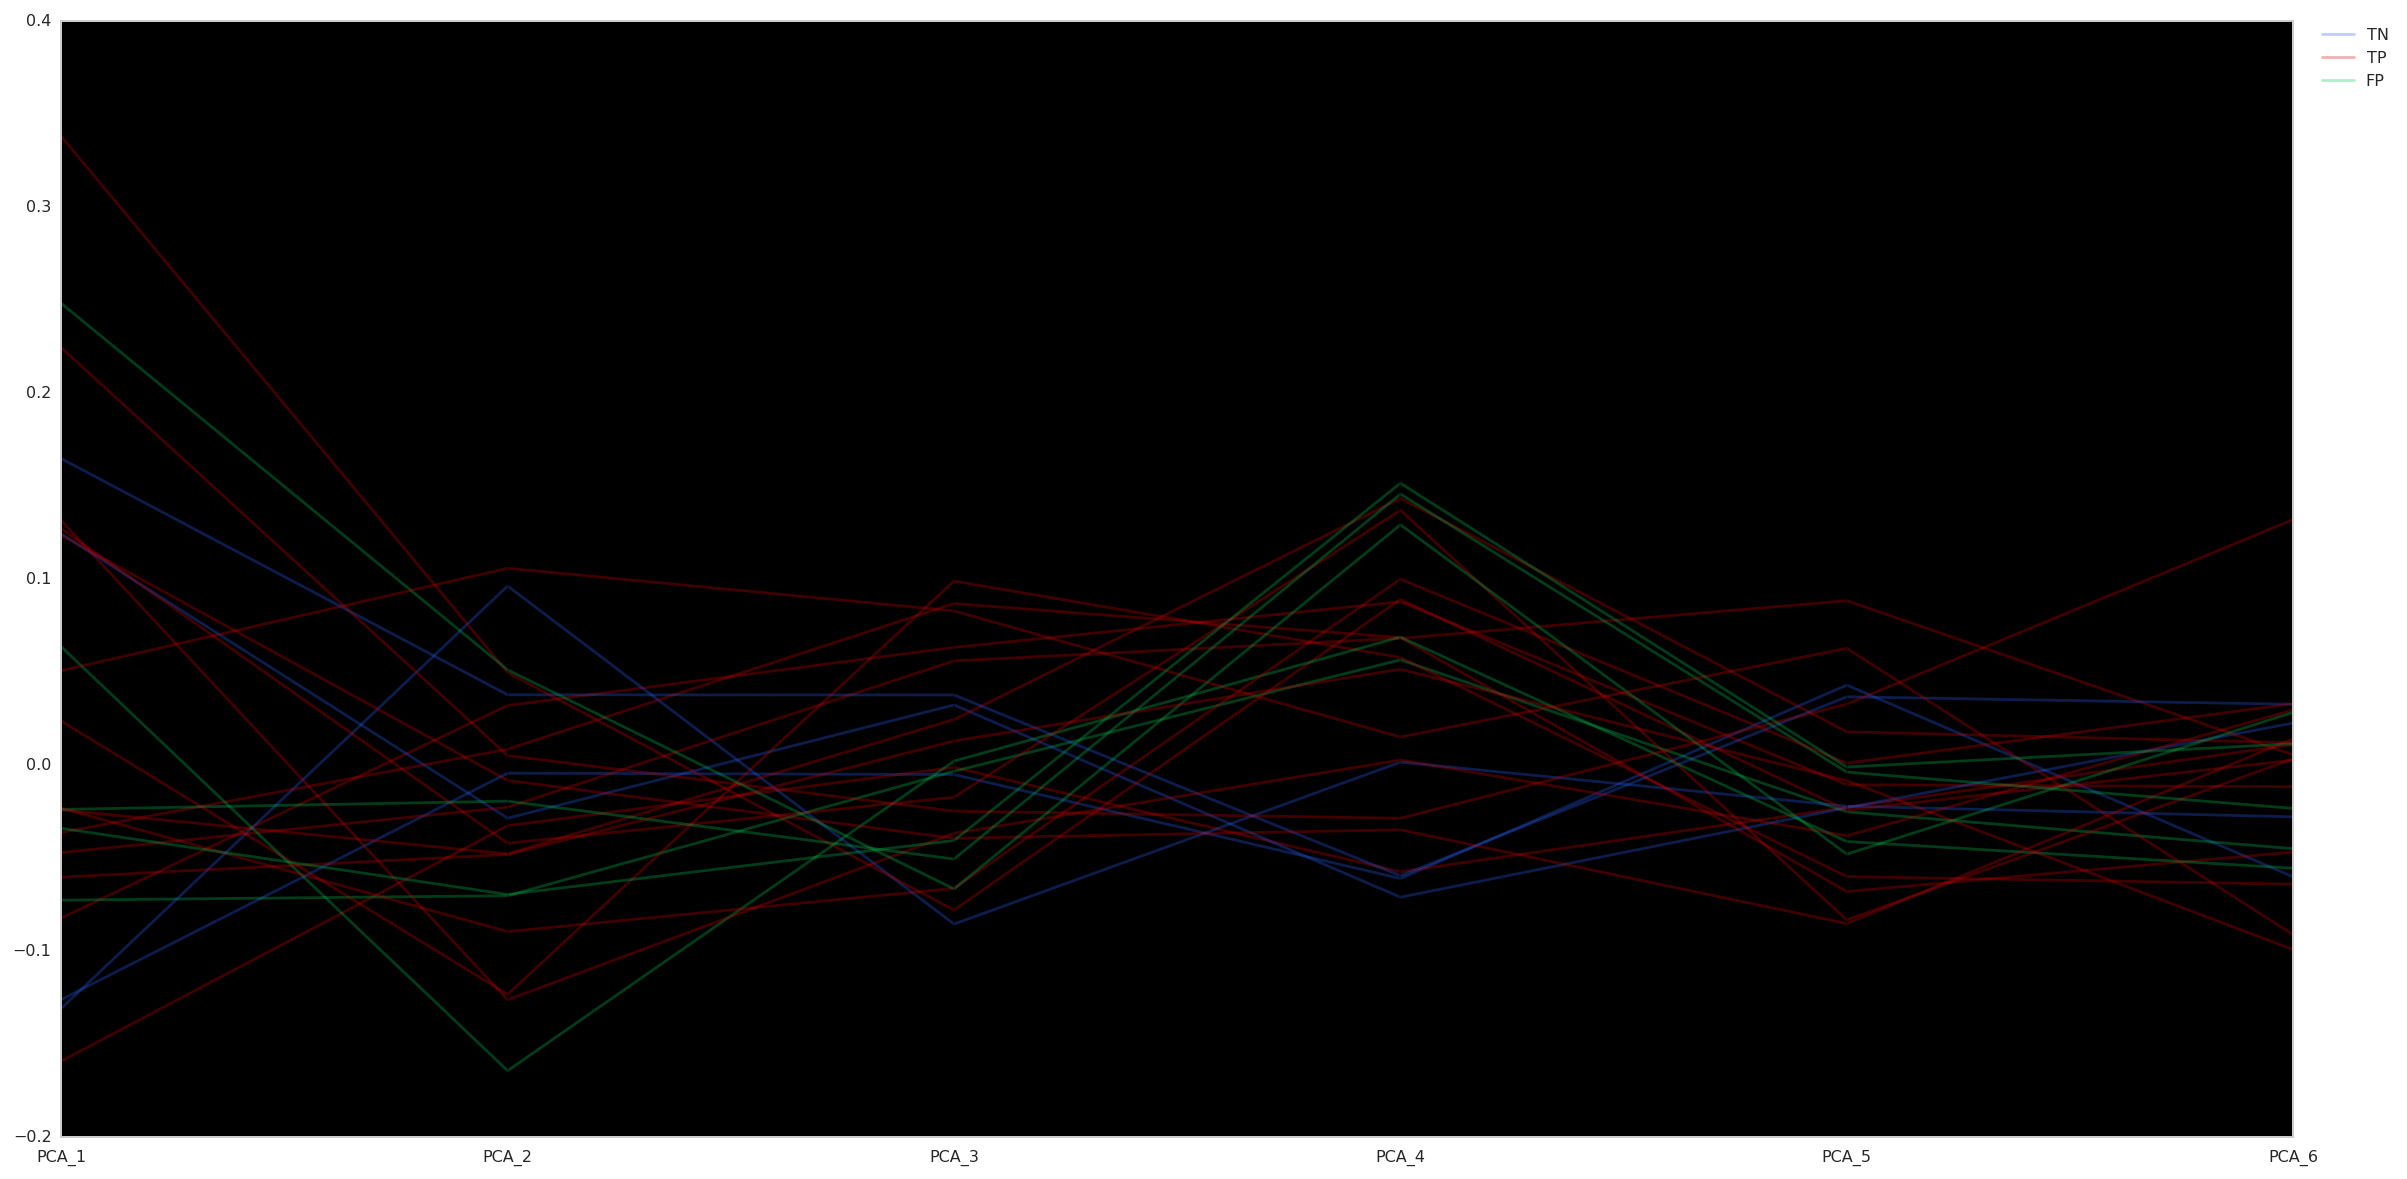

In [2239]:
from pandas.tools.plotting import parallel_coordinates
def plot_pca(n_components=None, scale=False, conf=.5):
    fig, ax = plt.subplots(figsize=(20,10))
    
    X = X_pca
    if n_components:
        X = X_pca[:,:n_components]
    if scale:
        X = preprocessing.scale(X)
    X_pca_df = pd.DataFrame(X, columns=["PCA_%d" % (i+1) for i in range(X.shape[1])])
    
    # align labels with X_pca
    classification_details_n = sorted([_ for _ in classification_details if _[1] == 0], key=lambda _:_[0])
    classification_details_s = sorted([_ for _ in classification_details if _[1] == 1], key=lambda _:_[0])
    sorted_classification_details = classification_details_n + classification_details_s
    
    classification_details_df = pd.DataFrame(sorted_classification_details, columns=['reference', 'y_true', 'y1_score', 'y_pred', 'indices'])
    kind_dict = {
        (0,0): "TN",
        (0,1): "FP",
        (1,0): "FN",
        (1,1): "TP"
    }

    # associate label with X_pca
    X_pca_df['kind'] = classification_details_df.apply(lambda r: kind_dict[(r.y_true, r.y_pred)], axis=1)
    
    # keep only prediction with a confidence of at least a given threshold
    keep = lambda t: [True if abs(_[2] - .5) > (t - .5) else False for _ in sorted_classification_details]
    kind_filter = X_pca_df.kind != 'FN'

    colors = [MD_COLORS.blue_A700, MD_COLORS.red_A700, MD_COLORS.green_A700]
    
    parallel_coordinates(X_pca_df[keep(conf) & kind_filter].sample(frac=1.), 'kind', ax=ax, color=colors)

    for l in fig.gca().lines:
        l.set_alpha(.3)
    ax.set_axis_bgcolor('k')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    

plot_pca(n_components=6, scale=False, conf=.61)